In [1]:
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
''')

# Imports

In [2]:
import pandas as pd
import geopandas as gpd
import sqlalchemy
import seaborn as sns
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
from sqlalchemy import text
import numpy as np
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json
import plotly.express as px
import folium
from folium.plugins import HeatMap

# SQL Connection Functions

In [3]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['database']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

srid = 4326 # Use WGS84
def make_wkt(geom,srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)


In [4]:
db, conn = pgconnect(credentials)

Connected successfully.


In [5]:
conn.execute(text("""
CREATE SCHEMA IF NOT EXISTS Greater_Sydney;
COMMIT;
"""))
conn.execute(text("SET search_path TO Greater_Sydney"))

In [6]:
from sqlalchemy import inspect
inspect(db).get_schema_names()

['greater_sydney', 'information_schema', 'public']

# Section 1

## Creating schema and setting search path

## SA2 Regions dataset

```sa2_regions``` table contains Statistical Area Level 2 (SA2) digital boundaries, filtered down to just the "Greater Sydney" GCC for relevancy and ease of access. Unneccessary columns such as duplicates or irrelevant information have been dropped.

### Renaming columns

**Old name = New name**

*SA2_CODE21* = sa2_code

*SA2_NAME21* = sa2_name

*AREASQKM21* = area

*geometry* = geom


*geometry* column has been applied WKT Element representation for SQL spatial data processing

In [7]:
df = gpd.read_file('SA2_2021_AUST_GDA2020.shp')

In [8]:
df.head()


,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,101021007,Braidwood,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3418.3525,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4..."
1,101021008,Karabar,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,6.9825,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21899 -35.36738, 149.21800 -35.3..."
2,101021009,Queanbeyan,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,4.7620,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3..."
3,101021010,Queanbeyan - East,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.0032,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3..."
4,101021012,Queanbeyan West - Jerrabomberra,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.6748,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.19572 -35.36126, 149.19970 -35.3..."


In [9]:
sa2_regions = df[df['GCC_NAME21'] == 'Greater Sydney']
sa2_regions = sa2_regions.drop(columns=['GCC_CODE21', 'GCC_NAME21',
                          'SA3_CODE21', 'SA3_NAME21',
                          'SA4_CODE21', 'SA4_NAME21',
                          'STE_CODE21', 'STE_NAME21',
                          'AUS_CODE21', 'AUS_NAME21',
                          'CHG_FLAG21', 'CHG_LBL21',
                          'LOCI_URI21'])
sa2_regions.head()

,SA2_CODE21,SA2_NAME21,AREASQKM21,geometry
28,102011028,Avoca Beach - Copacabana,6.4376,"POLYGON ((151.41373 -33.46558, 151.41362 -33.4..."
29,102011029,Box Head - MacMasters Beach,32.0802,"POLYGON ((151.37484 -33.50052, 151.37507 -33.5..."
30,102011030,Calga - Kulnura,767.9512,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448..."
31,102011031,Erina - Green Point,33.7934,"POLYGON ((151.37194 -33.43698, 151.37288 -33.4..."
32,102011032,Gosford - Springfield,16.9123,"POLYGON ((151.32349 -33.42779, 151.32342 -33.4..."


In [10]:
sa2_regions.columns = [
    'sa2_code',
    'sa2_name',
    'area',
    'geometry'
]
sa2_regions['sa2_code'] = sa2_regions['sa2_code'].astype('int32')

In [11]:
sa2_regions.head()

,sa2_code,sa2_name,area,geometry
28,102011028,Avoca Beach - Copacabana,6.4376,"POLYGON ((151.41373 -33.46558, 151.41362 -33.4..."
29,102011029,Box Head - MacMasters Beach,32.0802,"POLYGON ((151.37484 -33.50052, 151.37507 -33.5..."
30,102011030,Calga - Kulnura,767.9512,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448..."
31,102011031,Erina - Green Point,33.7934,"POLYGON ((151.37194 -33.43698, 151.37288 -33.4..."
32,102011032,Gosford - Springfield,16.9123,"POLYGON ((151.32349 -33.42779, 151.32342 -33.4..."


In [12]:
sa2_regions['geom'] = sa2_regions['geometry'].apply(lambda x : make_wkt(x, srid) if x else x)
sa2_regions = sa2_regions.drop(columns=['geometry'])
sa2_regions.head()

,sa2_code,sa2_name,area,geom
28,102011028,Avoca Beach - Copacabana,6.4376,MULTIPOLYGON (((151.413733024921 -33.465580583...
29,102011029,Box Head - MacMasters Beach,32.0802,MULTIPOLYGON (((151.37484081570685 -33.5005199...
30,102011030,Calga - Kulnura,767.9512,MULTIPOLYGON (((151.20449037540152 -33.5328022...
31,102011031,Erina - Green Point,33.7934,MULTIPOLYGON (((151.37193611462118 -33.4369790...
32,102011032,Gosford - Springfield,16.9123,MULTIPOLYGON (((151.32348639265098 -33.4277852...


In [13]:
area_ref = sa2_regions[['sa2_code', 'sa2_name']].drop_duplicates().reset_index(drop=True)
area_ref

,sa2_code,sa2_name
0,102011028,Avoca Beach - Copacabana
1,102011029,Box Head - MacMasters Beach
2,102011030,Calga - Kulnura
3,102011031,Erina - Green Point
4,102011032,Gosford - Springfield
...,...,...
368,128021537,Royal National Park
369,128021538,Sutherland - Kirrawee
370,128021607,Engadine
371,128021608,Loftus - Yarrawarrah


In [14]:
sa2_regions = sa2_regions.drop(columns=['sa2_name']).reset_index(drop=True)

### Creating and importing dataframe to SQL server

In [15]:
conn.execute(text(f"""
DROP TABLE IF EXISTS area_ref CASCADE;
CREATE TABLE area_ref (
    sa2_code VARCHAR(15) PRIMARY KEY,
    sa2_name VARCHAR(50)
);
"""))
area_ref.to_sql('area_ref', conn, if_exists='append', index=False)
query(conn, "select * from area_ref")

,sa2_code,sa2_name
0,102011028,Avoca Beach - Copacabana
1,102011029,Box Head - MacMasters Beach
2,102011030,Calga - Kulnura
3,102011031,Erina - Green Point
4,102011032,Gosford - Springfield
...,...,...
368,128021537,Royal National Park
369,128021538,Sutherland - Kirrawee
370,128021607,Engadine
371,128021608,Loftus - Yarrawarrah


In [16]:
conn.execute(text(f"""
CREATE EXTENSION IF NOT EXISTS postgis;
DROP TABLE IF EXISTS sa2_regions CASCADE;
CREATE TABLE sa2_regions (
    sa2_code VARCHAR(15) PRIMARY KEY,
    area NUMERIC,
    geom GEOMETRY(MULTIPOLYGON, {srid}),
    FOREIGN KEY (sa2_code) REFERENCES area_ref(sa2_code)
);
create index sa2_regions_geom_idx on sa2_regions using gist(geom)
"""))
sa2_regions.to_sql('sa2_regions', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from sa2_regions")

,sa2_code,area,geom
0,102011028,6.4376,0106000020E6100000010000000103000000010000005E...
1,102011029,32.0802,0106000020E61000000100000001030000000100000010...
2,102011030,767.9512,0106000020E61000000200000001030000000100000085...
3,102011031,33.7934,0106000020E61000000100000001030000000100000041...
4,102011032,16.9123,0106000020E6100000010000000103000000010000007E...
...,...,...,...
368,128021537,139.3336,0106000020E61000000100000001030000000100000046...
369,128021538,7.7550,0106000020E61000000100000001030000000100000089...
370,128021607,8.9538,0106000020E6100000010000000103000000010000008E...
371,128021608,3.8436,0106000020E610000001000000010300000001000000A1...


## Business dataset

```businesses``` table contains number of businesses by industry and SA2 region, reported by turnover size ranges.

### Renaming columns

**Old name** = **New name**

*industry_code* = ind_code

*industry_name* = ind_name

*sa2_code* = area_code

*sa2_name* = area_name

*0_to_50k_businesses* = buss_1

*50k_to_200k_businesses* = buss_2

*200k_to_2m_businesses* = buss_3

*2m_to_5m_businesses* = buss_4

*5m_to_10m_businesses* = buss_5 

*10m_or_more_businesses* = buss_6

*total_businesses* = total_no

In [17]:
businesses = pd.read_csv('Businesses.csv')

In [18]:
businesses.columns = [
    'ind_code', 'ind_name',
    'sa2_code', 'sa2_name',
    'buss_1', 'buss_2', 'buss_3', 'buss_4', 'buss_5', 'buss_6', 'total_no'
]
businesses['sa2_code'] = businesses['sa2_code'].astype('int32')
businesses = businesses.loc[businesses['sa2_code'].isin(sa2_regions['sa2_code'].values)]

In [19]:
businesses.head()

,ind_code,ind_name,sa2_code,sa2_name,buss_1,buss_2,buss_3,buss_4,buss_5,buss_6,total_no
28,A,"Agriculture, Forestry and Fishing",102011028,Avoca Beach - Copacabana,3,0,3,0,0,0,6
29,A,"Agriculture, Forestry and Fishing",102011029,Box Head - MacMasters Beach,8,6,3,0,0,0,17
30,A,"Agriculture, Forestry and Fishing",102011030,Calga - Kulnura,69,43,94,5,3,3,215
31,A,"Agriculture, Forestry and Fishing",102011031,Erina - Green Point,12,8,4,3,0,0,27
32,A,"Agriculture, Forestry and Fishing",102011032,Gosford - Springfield,8,5,6,0,0,0,19


In [20]:
industries = businesses[['ind_code', 'ind_name']].drop_duplicates().reset_index(drop=True) #Reference table
industries

,ind_code,ind_name
0,A,"Agriculture, Forestry and Fishing"
1,B,Mining
2,C,Manufacturing
3,D,"Electricity, Gas, Water and Waste Services"
4,E,Construction
5,F,Wholesale Trade
6,G,Retail Trade
7,H,Accommodation and Food Services
8,I,"Transport, Postal and Warehousing"
9,J,Information Media and Telecommunications


In [21]:
businesses = businesses.drop(columns=['ind_name'])
businesses

,ind_code,sa2_code,sa2_name,buss_1,buss_2,buss_3,buss_4,buss_5,buss_6,total_no
28,A,102011028,Avoca Beach - Copacabana,3,0,3,0,0,0,6
29,A,102011029,Box Head - MacMasters Beach,8,6,3,0,0,0,17
30,A,102011030,Calga - Kulnura,69,43,94,5,3,3,215
31,A,102011031,Erina - Green Point,12,8,4,3,0,0,27
32,A,102011032,Gosford - Springfield,8,5,6,0,0,0,19
...,...,...,...,...,...,...,...,...,...,...
12211,S,128021537,Royal National Park,0,0,0,0,0,0,0
12212,S,128021538,Sutherland - Kirrawee,21,66,58,3,3,0,152
12213,S,128021607,Engadine,13,41,31,3,0,0,87
12214,S,128021608,Loftus - Yarrawarrah,0,10,10,0,0,0,22


### Creating and importing dataframe to SQL server

In [22]:
conn.execute(text(f"""
DROP TABLE IF EXISTS industries CASCADE;
CREATE TABLE industries (
    ind_code CHAR(1) PRIMARY KEY,
    ind_name VARCHAR              
);
"""))
industries.to_sql('industries', conn, if_exists='append', index=False)
query(conn, 'select * from industries')

,ind_code,ind_name
0,A,"Agriculture, Forestry and Fishing"
1,B,Mining
2,C,Manufacturing
3,D,"Electricity, Gas, Water and Waste Services"
4,E,Construction
5,F,Wholesale Trade
6,G,Retail Trade
7,H,Accommodation and Food Services
8,I,"Transport, Postal and Warehousing"
9,J,Information Media and Telecommunications


In [23]:
conn.execute(text(f"""
DROP TABLE IF EXISTS businesses CASCADE;
CREATE TABLE businesses (
    ind_code CHAR(1) REFERENCES industries(ind_code),
    sa2_code VARCHAR(15),
    sa2_name VARCHAR(100),
    buss_1 INTEGER,
    buss_2 INTEGER,
    buss_3 INTEGER,
    buss_4 INTEGER,
    buss_5 INTEGER,
    buss_6 INTEGER,
    total_no INTEGER NOT NULL,
    PRIMARY KEY (ind_code, sa2_code),
    FOREIGN KEY (sa2_code) REFERENCES sa2_regions(sa2_code)     
);
create index businesss_total_no on businesses(total_no);
"""))
businesses.to_sql('businesses', conn, if_exists='append', index=False)
query(conn, 'select * from businesses')

,ind_code,sa2_code,sa2_name,buss_1,buss_2,buss_3,buss_4,buss_5,buss_6,total_no
0,A,102011028,Avoca Beach - Copacabana,3,0,3,0,0,0,6
1,A,102011029,Box Head - MacMasters Beach,8,6,3,0,0,0,17
2,A,102011030,Calga - Kulnura,69,43,94,5,3,3,215
3,A,102011031,Erina - Green Point,12,8,4,3,0,0,27
4,A,102011032,Gosford - Springfield,8,5,6,0,0,0,19
...,...,...,...,...,...,...,...,...,...,...
7082,S,128021537,Royal National Park,0,0,0,0,0,0,0
7083,S,128021538,Sutherland - Kirrawee,21,66,58,3,3,0,152
7084,S,128021607,Engadine,13,41,31,3,0,0,87
7085,S,128021608,Loftus - Yarrawarrah,0,10,10,0,0,0,22


## Stops dataset

```stops``` table contains locations of all public transport stops (trains and bus) in GTFS format.

### Renaming columns

*Column names stay the same*

Convert longitude and latitude columns into geopandas "points", which will be later converted into WKT Element.

In [24]:
stops = pd.read_csv("Stops.txt", sep=",")
stops.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,platform_code
0,200039,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0,NaN
1,200054,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0,NaN
2,200060,NaN,Central Station,-33.884084,151.206292,1.0,NaN,0,NaN
3,201510,NaN,Redfern Station,-33.891690,151.198866,1.0,NaN,0,NaN
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0,NaN


In [25]:
stops['geom'] = gpd.points_from_xy(stops.stop_lon, stops.stop_lat)

### Creating and importing dataframe to SQL server

In [26]:
stops['geom'] = stops['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid) if x else x)
stops['stop_code'] = stops['stop_code'].fillna(0).astype('int32')
stops = stops.drop(columns=['stop_lat', 'stop_lon',
                            'location_type', 'platform_code',
                            'wheelchair_boarding' ])
stops

,stop_id,stop_code,stop_name,parent_station,geom
0,200039,200039,"Central Station, Eddy Av, Stand A",200060,POINT (151.20666465471 -33.8822064874687)
1,200054,200054,"Central Station, Eddy Av, Stand D",200060,POINT (151.20699145565 -33.8820421431408)
2,200060,0,Central Station,NaN,POINT (151.206292455081 -33.8840842535493)
3,201510,0,Redfern Station,NaN,POINT (151.198866071817 -33.8916900512711)
4,201646,201646,"Redfern Station, Gibbons St, Stand B",201510,POINT (151.198881722942 -33.8933293130144)
...,...,...,...,...,...
114713,212753,212753,"Sydney Olympic Park Wharf, Side B",21271,POINT (151.07879697831 -33.8220164586429)
114714,2137185,2137185,"Cabarita Wharf, Side A",21371,POINT (151.116926480557 -33.8406690716775)
114715,2137186,2137186,"Cabarita Wharf, Side B",21371,POINT (151.116898892402 -33.8407691073139)
114716,21501,21501,Parramatta Wharf,2150112,POINT (151.010576673346 -33.8139042429414)


In [27]:
conn.execute(text(f"""
DROP TABLE IF EXISTS stops CASCADE;
CREATE TABLE stops (
    stop_id VARCHAR(15) PRIMARY KEY,
    stop_code INTEGER,
    stop_name VARCHAR,
    parent_station VARCHAR(15),
    geom GEOMETRY(POINT, {srid})
);
create index stops_geom_idx on stops using gist(geom)
"""))
stops.to_sql('stops', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, 'select * from stops')

,stop_id,stop_code,stop_name,parent_station,geom
0,200039,200039,"Central Station, Eddy Av, Stand A",200060,0101000020E6100000FFA631FF9CE66240A1FF6524ECF0...
1,200054,200054,"Central Station, Eddy Av, Stand D",200060,0101000020E61000002F928BAC9FE66240E33DC7C1E6F0...
2,200060,0,Central Station,None,0101000020E6100000817FA2F299E662408FF33DAC29F1...
3,201510,0,Redfern Station,None,0101000020E61000009E57611C5DE6624060304CE622F2...
4,201646,201646,"Redfern Station, Gibbons St, Stand B",201510,0101000020E6100000DBF9333D5DE662403DFA6B9D58F2...
...,...,...,...,...,...
114713,212753,212753,"Sydney Olympic Park Wharf, Side B",21271,0101000020E6100000AF9B3D8185E262408F52D7D537E9...
114714,2137185,2137185,"Cabarita Wharf, Side A",21371,0101000020E6100000EB409ADCBDE3624089CE4C0B9BEB...
114715,2137186,2137186,"Cabarita Wharf, Side B",21371,0101000020E6100000C4F9BEA2BDE362403EB375529EEB...
114716,21501,21501,Parramatta Wharf,2150112,0101000020E6100000E443E4A456E0624025C1A4032EE8...


## Polls dataset

```polls``` table contains locations of polling places for the 2019 Federal election.

### Renaming columns

*Column names stay the same*

The *geom* column is faulty so it is dropped. Convert longitude and latitude columns into geopandas "points", which will be later converted into WKT Element.

In [28]:
polls = pd.read_csv("PollingPlaces2019.csv")
polls

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,ORANGE,NSW,2800.0,NaN,NaN,NaN
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,NaN,NaN,BARRACK HEIGHTS,NSW,2528.0,-34.564200,150.858000,POINT (-34.5642 150.858)
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,NaN,NaN,NaN,WARILLA,NSW,2528.0,-34.550823,150.859755,POINT (-34.5508228 150.8597546)
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,NaN,NaN,WELBY,NSW,2575.0,-34.440900,150.424000,POINT (-34.4409 150.424)
2928,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,564,1,Windang,Windang Public School,60-64 Oakland Ave,NaN,NaN,WINDANG,NSW,2528.0,-34.531600,150.866000,POINT (-34.5316 150.866)


In [29]:
polls['geom'] = gpd.points_from_xy(polls.longitude, polls.latitude)

Converting longitudes and latitudes into geom points with SRID WGS84 to be more consistent, dropping irrelevant columns

In [30]:
divisions = polls[['division_id','division_name']].drop_duplicates().reset_index(drop=True)

In [31]:
polls = polls.drop(columns=['FID', 'latitude',
                            'longitude', 'premises_address_1',
                            'premises_address_2','premises_address_3',
                            'state', 'premises_state_abbreviation',
                            'the_geom', 'division_name',
                            'polling_place_type_id', 'premises_name',
                            'polling_place_name'])
polls['premises_post_code'] = polls['premises_post_code'].fillna(0).astype('int32')
polls['geom'] = polls['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid) if x else None)
polls

,division_id,polling_place_id,premises_suburb,premises_post_code,geom
0,104,33595,NaN,0,None
1,105,33596,NaN,0,None
2,107,33600,NaN,0,None
3,109,33603,ORANGE,2800,None
4,113,33716,NaN,0,None
...,...,...,...,...,...
2925,150,2809,BARRACK HEIGHTS,2528,POINT (150.858 -34.5642)
2926,150,58798,WARILLA,2528,POINT (150.8597546 -34.5508228)
2927,150,31242,WELBY,2575,POINT (150.424 -34.4409)
2928,150,564,WINDANG,2528,POINT (150.866 -34.5316)


### Creating and importing dataframe to SQL server

In [32]:
conn.execute(text(f"""
DROP TABLE IF EXISTS divisions CASCADE;
CREATE TABLE divisions (
    division_id VARCHAR(15),
    division_name VARCHAR     
);
"""))
divisions.to_sql('divisions', conn, if_exists='append', index=False)
query(conn, 'select * from divisions')

,division_id,division_name
0,104,Barton
1,105,Bennelong
2,107,Blaxland
3,109,Calare
4,113,Cowper
5,121,Grayndler
6,126,Hunter
7,127,Kingsford Smith
8,249,Paterson
9,144,Reid


In [33]:
conn.execute(text(f"""
DROP TABLE IF EXISTS polls CASCADE;
CREATE TABLE polls (            
    division_id VARCHAR(15),
    polling_place_id VARCHAR(15) PRIMARY KEY,              
    premises_suburb VARCHAR,
    premises_post_code INTEGER,
    geom GEOMETRY(POINT, {srid})
);
create index polls_geom_idx on polls using gist(geom)
"""))
polls.to_sql('polls', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, 'select * from polls')

,division_id,polling_place_id,premises_suburb,premises_post_code,geom
0,104,33595,None,0,None
1,105,33596,None,0,None
2,107,33600,None,0,None
3,109,33603,ORANGE,2800,None
4,113,33716,None,0,None
...,...,...,...,...,...
2925,150,2809,BARRACK HEIGHTS,2528,0101000020E6100000FA7E6ABC74DB62409C33A2B43748...
2926,150,58798,WARILLA,2528,0101000020E6100000BD32141C83DB624011F28B5C8146...
2927,150,31242,WELBY,2575,0101000020E610000021B0726891CD6240386744696F38...
2928,150,564,WINDANG,2528,0101000020E6100000C1CAA145B6DB6240DC4603780B44...


## Schools dataset

```primary_school```, ```secondary_school```, ```future_school``` tables contain geographical regions in which students must live to attend primary, secondary and future Government school.

### Renaming columns

*USE_ID* = id

*USE_DESC* = name

*geometry* - geometry

Convert every value in *geometry* column for data type unification

In [34]:
df_primary = gpd.read_file("Catchments/catchments/catchments_primary.shp")
df_secondary = gpd.read_file("Catchments/catchments/catchments_secondary.shp")
df_future = gpd.read_file("Catchments/catchments/catchments_future.shp")

In [35]:
df_primary.head()

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
3,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
4,3918,PRIMARY,Killara PS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.15379 -33.75586, 151.15404 -33.7..."


In [36]:
df_secondary.head()

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.67182 -35.31444, 146.68930 -35.3..."
1,8266,HIGH_COED,James Fallon HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((147.08734 -35.86271, 147.10413 -35.8..."
2,8505,HIGH_COED,Murray HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.81448 -35.78341, 146.81250 -35.7..."
3,8458,HIGH_COED,Kingswood HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"MULTIPOLYGON (((150.68600 -33.74031, 150.68631..."
4,8559,HIGH_COED,Jamison HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((150.69513 -33.75627, 150.68936 -33.7..."


In [37]:
df_future.head()

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geometry
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.19849 -33.53990, 151.19945 -33.5..."
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.27152 -33.91402, 151.27152 -33.9..."
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,"POLYGON ((151.15292 -33.83939, 151.16144 -33.8..."
3,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.17794 -33.69820, 151.17859 -33.6..."
4,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.28072 -33.83287, 151.28095 -33.8..."


In [38]:
df_primary = df_primary.drop(columns=['CATCH_TYPE', 'ADD_DATE',
                                      'KINDERGART', 'YEAR1',
                                      'YEAR2', 'YEAR3',
                                      'YEAR4','YEAR5',
                                      'YEAR6','YEAR7',
                                      'YEAR8','YEAR9',
                                      'YEAR10','YEAR11',
                                      'YEAR12','PRIORITY'])
df_primary.columns = ['id', 'name', 'geometry']
df_primary['id'] = df_primary['id'].astype('int32')
df_primary.head()

,id,name,geometry
0,2838,Parklea PS,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,2404,Lindfield EPS,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
2,4393,Carlingford WPS,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
3,4615,Caddies Ck PS,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
4,3918,Killara PS,"POLYGON ((151.15379 -33.75586, 151.15404 -33.7..."


In [39]:
df_secondary = df_secondary.drop(columns=['CATCH_TYPE', 'ADD_DATE',
                                      'KINDERGART', 'YEAR1',
                                      'YEAR2', 'YEAR3',
                                      'YEAR4','YEAR5',
                                      'YEAR6','YEAR7',
                                      'YEAR8','YEAR9',
                                      'YEAR10','YEAR11',
                                      'YEAR12','PRIORITY'])
df_secondary.columns = ['id', 'name', 'geometry']
df_secondary['id'] = df_secondary['id'].astype('int32')
df_secondary.head()

,id,name,geometry
0,8503,Billabong HS,"POLYGON ((146.67182 -35.31444, 146.68930 -35.3..."
1,8266,James Fallon HS,"POLYGON ((147.08734 -35.86271, 147.10413 -35.8..."
2,8505,Murray HS,"POLYGON ((146.81448 -35.78341, 146.81250 -35.7..."
3,8458,Kingswood HS,"MULTIPOLYGON (((150.68600 -33.74031, 150.68631..."
4,8559,Jamison HS,"POLYGON ((150.69513 -33.75627, 150.68936 -33.7..."


In [40]:
df_future = df_future.drop(columns=['CATCH_TYPE', 'ADD_DATE',
                                      'KINDERGART', 'YEAR1',
                                      'YEAR2', 'YEAR3',
                                      'YEAR4','YEAR5',
                                      'YEAR6','YEAR7',
                                      'YEAR8','YEAR9',
                                      'YEAR10','YEAR11',
                                      'YEAR12'])
df_future.columns = ['id', 'name', 'geometry']
df_future['id'] = df_future['id'].astype('int32')
df_future.head()

,id,name,geometry
0,8416,Ku-ring-gai HS,"POLYGON ((151.19849 -33.53990, 151.19945 -33.5..."
1,8161,Randwick BHS,"POLYGON ((151.27152 -33.91402, 151.27152 -33.9..."
2,8539,SSC Blackwattle Bay,"POLYGON ((151.15292 -33.83939, 151.16144 -33.8..."
3,8400,St Ives HS,"POLYGON ((151.17794 -33.69820, 151.17859 -33.6..."
4,8555,Rose Bay SC,"POLYGON ((151.28072 -33.83287, 151.28095 -33.8..."


In [41]:
df_primary["geom"] = df_primary["geometry"].apply(lambda x: make_wkt(x,srid) if x else x)
df_secondary["geom"] = df_secondary["geometry"].apply(lambda x: make_wkt(geom=x,srid=srid) if x else x)
df_future["geom"] = df_future["geometry"].apply(lambda x: make_wkt(geom=x,srid=srid) if x else x)

df_primary = df_primary.drop(columns=['geometry'])
df_secondary = df_secondary.drop(columns=['geometry'])
df_future = df_future.drop(columns=['geometry'])

In [42]:
conn.execute(text(f"""
DROP TABLE IF EXISTS primary_school CASCADE;
CREATE TABLE primary_school (
    id VARCHAR(15) PRIMARY KEY,
    name VARCHAR,
    geom GEOMETRY(MULTIPOLYGON, {srid})
);
"""))
df_primary.to_sql('primary_school', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, 'select * from primary_school')

,id,name,geom
0,2838,Parklea PS,0106000020E61000000100000001030000000100000078...
1,2404,Lindfield EPS,0106000020E610000001000000010300000001000000BE...
2,4393,Carlingford WPS,0106000020E61000000100000001030000000100000065...
3,4481,St Andrews PS,0106000020E61000000100000001030000000100000040...
4,4615,Caddies Ck PS,0106000020E61000000100000001030000000100000056...
...,...,...,...
1657,2409,Lismore SPS,0106000020E610000001000000010300000001000000C9...
1658,4383,E A Southee PS,0106000020E610000001000000010300000001000000B9...
1659,3275,Tumbarumba PS,0106000020E610000001000000010300000001000000C0...
1660,2239,Jindera PS,0106000020E610000001000000010300000001000000F6...


### Creating and importing dataframe to SQL server

In [43]:
conn.execute(text(f"""
DROP TABLE IF EXISTS secondary_school CASCADE;
CREATE TABLE secondary_school (
    id VARCHAR(15) PRIMARY KEY,
    name VARCHAR,
    geom GEOMETRY(MULTIPOLYGON, {srid})
);
"""))
df_secondary.to_sql('secondary_school', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, 'select * from secondary_school')

,id,name,geom
0,8503,Billabong HS,0106000020E6100000010000000103000000010000006D...
1,8266,James Fallon HS,0106000020E61000000100000001030000000100000071...
2,8559,Jamison HS,0106000020E6100000010000000103000000020000002F...
3,8502,Tomaree HS,0106000020E6100000010000000103000000010000003B...
4,8505,Murray HS,0106000020E6100000010000000103000000010000003F...
...,...,...,...
431,8213,Birrong BHS,0106000020E61000000100000001030000000100000040...
432,8108,Cessnock HS,0106000020E610000001000000010300000001000000AD...
433,3235,Tooleybuc CS,0106000020E6100000010000000103000000010000003E...
434,1115,Balranald CS,0106000020E6100000010000000103000000010000005B...


In [44]:
conn.execute(text(f"""
DROP TABLE IF EXISTS future_school CASCADE;
CREATE TABLE future_school (
    id VARCHAR(15) PRIMARY KEY,
    name VARCHAR,
    geom GEOMETRY(MULTIPOLYGON, {srid})
);
"""))
df_future.to_sql('future_school', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, 'select * from future_school')

,id,name,geom
0,8416,Ku-ring-gai HS,0106000020E61000000100000001030000000100000090...
1,8161,Randwick BHS,0106000020E6100000010000000103000000010000006F...
2,8539,SSC Blackwattle Bay,0106000020E610000001000000010300000001000000E3...
3,8286,Mt Annan HS,0106000020E61000000100000001030000000100000099...
4,4524,Hastings PS,0106000020E61000000100000001030000000100000060...
5,8554,HSC Westport,0106000020E610000001000000010300000001000000FE...
6,8400,St Ives HS,0106000020E61000000100000001030000000100000060...
7,8555,Rose Bay SC,0106000020E6100000010000000103000000010000000C...
8,8135,Parramatta HS,0106000020E6100000010000000103000000010000001F...
9,8556,Alexandria Park CS,0106000020E61000000100000001030000000100000028...


In [45]:
conn.execute(text("""
drop table if exists school cascade;
create table school as
select * from primary_school
union all
select * from secondary_school
union all
select * from future_school
commit;
create index schools_geom_idx on school using gist(geom);
"""))

query(conn, 'select * from school')

,id,name,geom
0,2838,Parklea PS,0106000020E61000000100000001030000000100000078...
1,2404,Lindfield EPS,0106000020E610000001000000010300000001000000BE...
2,4393,Carlingford WPS,0106000020E61000000100000001030000000100000065...
3,4481,St Andrews PS,0106000020E61000000100000001030000000100000040...
4,4615,Caddies Ck PS,0106000020E61000000100000001030000000100000056...
...,...,...,...
2123,4400,St Ives Park PS,0106000020E610000001000000010300000001000000C4...
2124,8216,Queanbeyan HS,0106000020E61000000100000001030000000100000043...
2125,8364,HSC Port Macquarie,0106000020E610000001000000010300000001000000D7...
2126,8395,Pendle Hill HS,0106000020E6100000010000000103000000010000004A...


## Population dataset

```population``` dataset contains the estimates of the number of people living in each SA2 by age range

### Renaming columns

*sa2_code* = area_code

*0-4_people* = age_group_0_4

*5-9_people* = age_group_5_9

*10-14_people* = age_group_10_14

*15-19_people* = age_group_15_19

*total_people* = total


In [46]:
df_pop = pd.read_csv('Population.csv')

In [47]:
df_pop.head()

,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346


In [48]:
df_pop = df_pop.drop(columns='sa2_name')

In [49]:
df_pop = df_pop[['sa2_code', '0-4_people',
                 '5-9_people','10-14_people',
                 '15-19_people','total_people']]

df_pop.columns = [
    'sa2_code', 'age_group_0_4',
    'age_group_5_9', 'age_group_10_14',
    'age_group_15_19', 'total']

df_pop['sa2_code'] = df_pop['sa2_code'].astype('int32')

In [50]:
df_pop.head()

,sa2_code,age_group_0_4,age_group_5_9,age_group_10_14,age_group_15_19,total
0,102011028,424,522,623,552,7530
1,102011029,511,666,702,592,11052
2,102011030,200,225,258,278,4748
3,102011031,683,804,880,838,14803
4,102011032,1164,1044,1084,1072,21346


### Creating and importing dataframe to SQL server

In [51]:
conn.execute(text(f"""
DROP TABLE IF EXISTS population CASCADE;
CREATE TABLE population (
    sa2_code VARCHAR(15) PRIMARY KEY,
    age_group_0_4 INTEGER,  
    age_group_5_9 INTEGER,
    age_group_10_14 INTEGER,
    age_group_15_19 INTEGER,
    total INTEGER,
    FOREIGN KEY (sa2_code) REFERENCES sa2_regions(sa2_code)
);
"""))
df_pop.to_sql('population', conn, if_exists='append', index=False)
query(conn, "select * from population")

,sa2_code,age_group_0_4,age_group_5_9,age_group_10_14,age_group_15_19,total
0,102011028,424,522,623,552,7530
1,102011029,511,666,702,592,11052
2,102011030,200,225,258,278,4748
3,102011031,683,804,880,838,14803
4,102011032,1164,1044,1084,1072,21346
...,...,...,...,...,...,...
368,128021537,2,4,10,4,45
369,128021538,1519,1292,1150,1117,23369
370,128021607,1157,1283,1469,1209,17379
371,128021608,503,487,575,508,7354


## Income dataset

```income``` table contrains total earnings statistics by SA2 (for later correlation analysis)

### Renaming columns

*sa2_code21* = area_code

*All the other column names remain the same*

In [52]:
df_income = pd.read_csv('Income.csv')

In [53]:
df_income.head()

,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981


In [54]:
df_income = df_income.drop(columns='sa2_name')
df_income = df_income[(df_income['earners'] !='np') | (df_income['mean_income'] != 'np') | (df_income['median_age'] != 'np') | (df_income['median_income'] != 'np')]

In [55]:
df_income.columns = [
    'sa2_code', 'earners',
    'median_age', 'median_income',
    'mean_income'
]
df_income['sa2_code'] = df_income['sa2_code'].astype('int32')

In [56]:
df_income.head()

,sa2_code,earners,median_age,median_income,mean_income
0,101021007,2467,51,46640,68904
1,101021008,5103,42,65564,69672
2,101021009,7028,39,63528,69174
3,101021010,3398,39,66148,74162
4,101021012,8422,44,78630,91981


### Creating and importing dataframe to SQL server

In [57]:
conn.execute(text(f"""
DROP TABLE IF EXISTS income CASCADE;
CREATE TABLE income (
    sa2_code VARCHAR(15) PRIMARY KEY,
    earners INTEGER, 
    median_age INTEGER,
    median_income INTEGER,
    mean_income INTEGER
);
"""))
df_income.to_sql('income', conn, if_exists='append', index=False)
query(conn, "select * from income")

,sa2_code,earners,median_age,median_income,mean_income
0,101021007,2467,51,46640,68904
1,101021008,5103,42,65564,69672
2,101021009,7028,39,63528,69174
3,101021010,3398,39,66148,74162
4,101021012,8422,44,78630,91981
...,...,...,...,...,...
630,128021537,14,37,36980,47584
631,128021538,13895,41,64940,74867
632,128021607,10239,43,63695,72995
633,128021608,4424,45,63087,76440


In [58]:
conn.execute(text("""
drop view if exists median_income cascade;
create view median_income as
select a.sa2_code, i.median_income
from sa2_regions a
inner join population p using (sa2_code)
left join income i using (sa2_code)
where p.total >= 100;
"""))

query(conn, "select * from median_income")

,sa2_code,median_income
0,102011028,55065
1,102011029,51927
2,102011030,49168
3,102011031,51905
4,102011032,54372
...,...,...
355,128021536,67381
356,128021538,64940
357,128021607,63695
358,128021608,63087


# Section 2

## Calculating values per 1000 people

### Businesses

In [59]:
conn.execute(text("""
drop view if exists consumer_services_value cascade;
create view consumer_services_value as
select p.sa2_code, coalesce(sum(total_no)/(total/1000.0), 0) as "consumer_per_1k"
from population p
inner join sa2_regions a using (sa2_code) 
left join businesses b on (p.sa2_code = b.sa2_code) and (ind_code = 'G' or ind_code = 'H' or ind_code = 'R')
where p.total >= 100 and total is not null
group by p.sa2_code, p.total;
"""))
query(conn, "select * from consumer_services_value")

,sa2_code,consumer_per_1k
0,117031643,21.518375
1,128011606,13.046387
2,126021501,11.936678
3,123011700,7.979431
4,125041588,12.366860
...,...,...
355,125031484,9.124719
356,127031522,9.266502
357,125031480,10.573636
358,122031432,18.694049


In [60]:
conn.execute(text("""
drop view if exists other_services_value cascade;
create view other_services_value as 
select p.sa2_code, coalesce(sum(total_no)/(total/1000.0), 0) as "others_per_1k"
from population p
inner join sa2_regions a using (sa2_code) 
left join businesses b on (p.sa2_code = b.sa2_code) and (ind_code = 'N' or ind_code = 'I' or ind_code = 'Q' or ind_code = 'K')
where p.total >= 100
group by p.sa2_code, p.total;
"""))
query(conn, "select * from other_services_value")

,sa2_code,others_per_1k
0,117031643,29.335912
1,128011606,25.312221
2,126021501,30.001277
3,123011700,21.189822
4,125041588,35.241976
...,...,...
355,125031484,27.157931
356,127031522,24.851074
357,125031480,25.326073
358,122031432,29.752501


### Stops

In [61]:
conn.execute(text("""
drop view if exists stops_value cascade;
create view stops_value as
select sa2_code, count(stop_id)/(total/1000.0) as "stops_per_1k"
from population p 
inner join sa2_regions a using (sa2_code)
left join stops s on st_contains(a.geom, s.geom)
where total >= 100
group by sa2_code, total;
"""))
query(conn, "select * from stops_value")

,sa2_code,stops_per_1k
0,102011028,16.865870
1,102011029,19.453493
2,102011030,36.225779
3,102011031,19.252854
4,102011032,16.630750
...,...,...
355,128021536,11.466751
356,128021538,8.344388
357,128021607,12.716497
358,128021608,19.581180


### Polls

In [62]:
conn.execute(text("""
drop view if exists polling_value cascade;
create view polling_value as
select sa2_code, count(polling_place_id)/(total/1000.0) as "polls_per_1k"
from population pop
inner join sa2_regions a using (sa2_code)
left join polls pol on st_contains(a.geom, pol.geom)
where total >= 100
group by sa2_code, total;
"""))
query(conn, "select * from polling_value")

,sa2_code,polls_per_1k
0,117031643,0.322373
1,128011606,0.334523
2,126021501,0.191498
3,123011700,0.177321
4,125041588,0.500393
...,...,...
355,125031484,0.129735
356,127031522,0.120344
357,125031480,0.253261
358,122031432,0.263296


### Schools

In [63]:
conn.execute(text("""
drop view if exists schools_value cascade;
create view schools_value as
with population as (
select sa2_code, total,
	age_group_0_4 + age_group_5_9 + age_group_10_14 + age_group_15_19 as young_people, 
	geom
from sa2_regions
join population using (sa2_code)
where total >= 100
)
select sa2_code, count(id)/(young_people/1000.0) as "schools_per_1k"
from population p
left join school s on st_intersects(p.geom, s.geom)
	and (st_area(st_intersection(p.geom, s.geom))/st_area(s.geom)) > 0.5
group by sa2_code, young_people;
"""))

query(conn, "select * from schools_value")

,sa2_code,schools_per_1k
0,102011028,0.471476
1,102011029,1.214083
2,102011030,9.365245
3,102011031,1.248050
4,102011032,0.687443
...,...,...
355,128021536,1.126851
356,128021538,0.787712
357,128021607,0.781555
358,128021608,0.482393


## Creating z-score function

In [64]:
conn.execute(text("""
create or replace function sigmoid(x double precision) 
returns double precision as $$
begin
	return 1.0 / (1.0 + (exp(-x)));
end;
$$ language plpgsql immutable strict;
"""))

### Businesses

In [65]:
sql = """
with quartiles as (
    select 
        percentile_cont(0.25) within group (order by consumer_per_1k) as q1,
        percentile_cont(0.75) within group (order by consumer_per_1k) as q3
    from consumer_services_value
)
select *
from consumer_services_value
cross join quartiles
where consumer_per_1k < q1 - 5.5 * (q3 - q1) 
   OR consumer_per_1k > q3 + 5.5 * (q3 - q1);
"""

query(conn, sql)

,sa2_code,consumer_per_1k,q1,q3
0,117011320,100.591716,8.410722,15.534901
1,117031644,340.285401,8.410722,15.534901
2,117031645,59.667748,8.410722,15.534901
3,119011355,66.891892,8.410722,15.534901


In [66]:
conn.execute(text("""
drop view if exists consumer_z_score cascade;

create view consumer_z_score as
with z_scores as (
  select
    sa2_code,
    (consumer_per_1k - avg(consumer_per_1k) over()) / 
                  nullif(stddev_pop(consumer_per_1k) over (), 0) as consumer_z_score  
  from consumer_services_value
  where sa2_code not in ('117031644', '117011320', '119011355') 
)
select * from z_scores
union all
select '117031644', 0.0
union all
select '117011320', 0.0
union all
select '119011355', 0.0; 
"""))

query(conn, "select * from consumer_z_score")

,sa2_code,consumer_z_score
0,117031643,1.224823
1,128011606,0.022150
2,126021501,-0.135383
3,123011700,-0.697149
4,125041588,-0.074315
...,...,...
355,122031432,0.823885
356,119041670,-0.828300
357,117031644,0.000000
358,117011320,0.000000


In [67]:
sql = """
with quartiles as (
    select 
        percentile_cont(0.25) within group (order by others_per_1k) as q1,
        percentile_cont(0.75) within group (order by others_per_1k) as q3
    from other_services_value
)
select *
from other_services_value
cross join quartiles
where others_per_1k < q1 - 5.5 * (q3 - q1) 
   OR others_per_1k > q3 + 5.5 * (q3 - q1);
"""
query(conn, sql)

,sa2_code,others_per_1k,q1,q3
0,117011320,193.293886,20.503454,31.800785
1,121041417,162.108443,20.503454,31.800785
2,117031644,1609.220637,20.503454,31.800785
3,119011355,100.675676,20.503454,31.800785
4,118011341,101.925445,20.503454,31.800785


In [68]:
conn.execute(text("""
drop view if exists others_z_score cascade;

create view others_z_score as
with stats as (
  select avg(others_per_1k) as mean, stddev_pop(others_per_1k) as stddev
  from other_services_value
),
z_scores as (
  select
    sa2_code,
    (others_per_1k - mean) / nullif(stddev, 0) as others_z_score  
  from other_services_value, stats
  where sa2_code not in ('117031644') 
)
select * from z_scores
union all 
select '117031644', 0.0;
"""))

query(conn, "select * from others_z_score")

,sa2_code,others_z_score
0,117031643,-0.045412
1,128011606,-0.092760
2,126021501,-0.037583
3,123011700,-0.141269
4,125041588,0.024085
...,...,...
355,127031522,-0.098186
356,125031480,-0.092597
357,122031432,-0.040510
358,119041670,-0.047398


### Stops

In [69]:
sql = """
with quartiles as (
    select 
        percentile_cont(0.25) within group (order by stops_per_1k) as q1,
        percentile_cont(0.75) within group (order by stops_per_1k) as q3
    from stops_value
)
select *
from stops_value
cross join quartiles
where stops_per_1k < q1 - 5.5 * (q3 - q1) 
   OR stops_per_1k > q3 + 5.5 * (q3 - q1);
"""
query(conn, sql)

,sa2_code,stops_per_1k,q1,q3
0,102021049,67.677946,7.353085,13.355188
1,127021518,47.378105,7.353085,13.355188


In [70]:
conn.execute(text("""
drop view if exists stops_z_score cascade;
create view stops_z_score as
select 
    sa2_code, 
    (stops_per_1k - avg(stops_per_1k) over ()) / 
    nullif(stddev_pop(stops_per_1k) over (), 0) as stops_z_score
from stops_value
"""))
query(conn, "select * from stops_z_score")

,sa2_code,stops_z_score
0,102011028,0.867841
1,102011029,1.264174
2,102011030,3.833102
3,102011031,1.233443
4,102011032,0.831829
...,...,...
355,128021536,0.040884
356,128021538,-0.437352
357,128021607,0.232302
358,128021608,1.283731


### Polls

In [71]:
sql = """
with quartiles as (
    select 
        percentile_cont(0.25) within group (order by polls_per_1k) as q1,
        percentile_cont(0.75) within group (order by polls_per_1k) as q3
    from polling_value
)
select *
from polling_value
cross join quartiles
where polls_per_1k < q1 - 5.5 * (q3 - q1) 
   OR polls_per_1k > q3 + 5.5 * (q3 - q1);
"""
query(conn, sql)

,sa2_code,polls_per_1k,q1,q3
0,102011030,1.474305,0.192515,0.335087
1,117031644,7.805830,0.192515,0.335087
2,117031645,1.327042,0.192515,0.335087
3,125041717,1.475047,0.192515,0.335087


In [72]:
conn.execute(text("""
drop view if exists polls_z_score cascade;
create view polls_z_score as(
select 
    sa2_code, 
    (polls_per_1k - avg(polls_per_1k) over ()) / 
    nullif(stddev_pop(polls_per_1k) over (), 0) as polls_z_score
from polling_value
where sa2_code not in ('117031645')
);
select * from polls_z_score
union all 
select '117031645', 0.0;
"""))
query(conn, "select * from polls_z_score")

,sa2_code,polls_z_score
0,117031643,0.050087
1,128011606,0.078418
2,126021501,-0.255085
3,123011700,-0.288142
4,125041588,0.465191
...,...,...
354,125031484,-0.399100
355,127031522,-0.420998
356,125031480,-0.111067
357,122031432,-0.087666


### Schools

In [73]:
sql = """
with quartiles as (
    select 
        percentile_cont(0.25) within group (order by schools_per_1k) as q1,
        percentile_cont(0.75) within group (order by schools_per_1k) as q3
    from schools_value
)
select *
from schools_value
cross join quartiles
where schools_per_1k < q1 - 5.5 * (q3 - q1) 
   OR schools_per_1k > q3 + 5.5 * (q3 - q1);
"""
query(conn, sql)

,sa2_code,schools_per_1k,q1,q3
0,102011030,9.365245,0.290066,0.756339
1,115031299,6.622517,0.290066,0.756339
2,117011320,17.543860,0.290066,0.756339


In [74]:
conn.execute(text("""
drop view if exists schools_z_score cascade;
create view schools_z_score as(
select 
    sa2_code, 
    (schools_per_1k - avg(schools_per_1k) over ()) / 
    nullif(stddev_pop(schools_per_1k) over (), 0) as schools_z_score
from schools_value
where sa2_code not in ('117011320')
);
select * from schools_value
union all 
select '117011320', 0.0;
"""))
query(conn, "select * from schools_z_score")

,sa2_code,schools_z_score
0,102011028,-0.154196
1,102011029,0.918024
2,102011030,12.687145
3,102011031,0.967067
4,102011032,0.157629
...,...,...
354,128021536,0.792073
355,128021538,0.302404
356,128021607,0.293515
357,128021608,-0.138434


### Income

In [75]:
conn.execute(text("""
drop view if exists median_income cascade;
create view median_income as
select sa2_code, median_income
from income
right join (sa2_regions join population using(sa2_code)) using (sa2_code)
where total >= 100;
"""))

query(conn, "select * from median_income")

,sa2_code,median_income
0,102011028,55065
1,102011029,51927
2,102011030,49168
3,102011031,51905
4,102011032,54372
...,...,...
355,128021536,67381
356,128021538,64940
357,128021607,63695
358,128021608,63087


### Combined

In [76]:
conn.execute(text("""
drop view if exists combined_z_score cascade;
             
create view combined_z_score as
select
    coalesce(c.sa2_code, o.sa2_code, st.sa2_code, p.sa2_code, sc.sa2_code) as sa2_code,
    coalesce(c.consumer_z_score, 0) + coalesce(o.others_z_score, 0) +
    coalesce(st.stops_z_score, 0) + coalesce(p.polls_z_score, 0) +
    coalesce(sc.schools_z_score, 0) as combined_z_score
from consumer_z_score c
full outer join others_z_score o using (sa2_code)
full outer join stops_z_score st using (sa2_code)
full outer join polls_z_score p using (sa2_code)
full outer join schools_z_score sc using (sa2_code)             
"""))

query(conn, "select * from combined_z_score order by combined_z_score desc;")

,sa2_code,combined_z_score
0,117031644,20.570742
1,102011030,20.529314
2,115031299,10.937634
3,102021049,10.288537
4,127021518,8.389763
...,...,...
355,127011729,-3.081507
356,123011702,-3.241192
357,127031730,-3.318250
358,123021703,-3.343259


## Sigmoid scoring

In [77]:
conn.execute(text("""
drop view if exists score cascade;

create or replace view score as
select
    sa2_code,
    1 / (1 + exp(-combined_z_score)) as score
from combined_z_score;
"""))

query(conn, "select * from score")

,sa2_code,score
0,102011028,0.625511
1,102011029,0.792156
2,102011030,1.000000
3,102011031,0.960894
4,102011032,0.797483
...,...,...
355,128021536,0.482934
356,128021538,0.343104
357,128021607,0.433075
358,128021608,0.457575


## Overall view

In [78]:
conn.execute(text("""
drop view if exists overall_score_view cascade;
             
create view overall_view as
select *
from combined_z_score
natural join score   
natural join median_income;
"""))

query(conn, "select * from overall_view")

,sa2_code,combined_z_score,score,median_income
0,102011028,0.513007,0.625511,55065
1,102011029,1.337971,0.792156,51927
2,102011030,20.529314,1.000000,49168
3,102011031,3.201587,0.960894,51905
4,102011032,1.370634,0.797483,54372
...,...,...,...,...
355,128021536,-0.068291,0.482934,67381
356,128021538,-0.649494,0.343104,64940
357,128021607,-0.269317,0.433075,63695
358,128021608,-0.170110,0.457575,63087


In [79]:
conn.execute(text("""
drop view if exists overall_value_view cascade;
create view overall_value_view as
select *
from sa2_regions
natural join consumer_services_value
natural join other_services_value
natural join stops_value
natural join polling_value
natural join schools_value
natural join score
natural join median_income;
"""))

query(conn, "select * from overall_value_view")

,sa2_code,area,geom,consumer_per_1k,others_per_1k,stops_per_1k,polls_per_1k,schools_per_1k,score,median_income
0,102011028,6.4376,0106000020E6100000010000000103000000010000005E...,12.881806,23.240372,16.865870,0.265604,0.471476,0.625511,55065
1,102011029,32.0802,0106000020E61000000100000001030000000100000010...,10.314875,16.286645,19.453493,0.180963,1.214083,0.792156,51927
2,102011030,767.9512,0106000020E61000000200000001030000000100000085...,21.693345,35.172704,36.225779,1.474305,9.365245,1.000000,49168
3,102011031,33.7934,0106000020E61000000100000001030000000100000041...,18.374654,31.412552,19.252854,0.405323,1.248050,0.960894,51905
4,102011032,16.9123,0106000020E6100000010000000103000000010000007E...,15.506418,28.670477,16.630750,0.327930,0.687443,0.797483,54372
...,...,...,...,...,...,...,...,...,...,...
355,128021536,8.9053,0106000020E610000001000000010300000001000000EF...,7.810031,14.897747,11.466751,0.316013,1.126851,0.482934,67381
356,128021538,7.7550,0106000020E61000000100000001030000000100000089...,10.954684,21.567033,8.344388,0.256750,0.787712,0.343104,64940
357,128021607,8.9538,0106000020E6100000010000000103000000010000008E...,7.422752,11.393061,12.716497,0.402785,0.781555,0.433075,63695
358,128021608,3.8436,0106000020E610000001000000010300000001000000A1...,5.983138,10.470492,19.581180,0.271961,0.482393,0.457575,63087


# Section 3

## Data import and cleaning

In [80]:
# Dataset: Building Approvals, Australia, NSW, SA2 excel data cube, 2022-2023
# Source: https://www.abs.gov.au/statistics/industry/building-and-construction/building-approvals-australia/mar-2024/87310do002_202403.xlsx
building_approvals = pd.read_excel("building_approvals_2024.xlsx", sheet_name="Table_1")

# Dataset: Public Transport - Location Facilities and Operators, Updated 11/01/2024
# Source: https://opendata.transport.nsw.gov.au/dataset/25f006fd-d0fb-4a8e-bfda-7ea4033c1aeb/resource/e9d94351-f22d-46ea-b64d-10e7e238368a/download/locationfacilitydata.csv
location_facilities = pd.read_csv("locationfacilitydata.csv")

In [81]:
building_approvals.head(5)

,Unnamed: 0,Australian Bureau of Statistics,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,"87310DO002_202403 Building Approvals, Australi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Released at 11:30 am (Canberra time) Thu 9 May...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Table 1. NSW, SA2 excel data cube 2022-2023",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,New houses,New other residential building,Total dwellings,Value of new houses,Value of new other residential building,Value of alterations & additions including con...,Value of total residential building,Value of non-residential building,Value of total building
4,NaN,NaN,no.,no.,no.,$'000,$'000,$'000,$'000,$'000,$'000


In [82]:
location_facilities.head(5)

,LOCATION_NAME,TSN,LATITUDE,LONGITUDE,EFA_ID,PHONE,ADDRESS,FACILITIES,ACCESSIBILITY,TRANSPORT_MODE,MORNING_PEAK,AFTERNOON_PEAK,SHORT_PLATFORM
0,Abbotsford Wharf,2046158,-33.843674,151.128173,10102011,NaN,"Great North Rd, Abbotsford NSW 2046",Kiss and ride stopping area | Bike racks | Toi...,This location is Independent Access | Wheelcha...,"Bus, Ferry",NaN,NaN,False
1,Aberdeen Station,233610,-32.167104,150.892052,10101192,02 6543 1018,"Macqueen St, Aberdeen NSW 2336",Commuter car park | Emergency help point | No ...,This location is Independent Access | Wheelcha...,Train,6.00-10am,3.00-7pm,True
2,Adamstown Station,228920,-32.933730,151.720081,10101159,02 4962 9295,"Park Ave, Adamstown NSW 2289",Commuter car park | Wheelchair accessible car ...,This location is Independent Access | Wheelcha...,"Train, Bus",6.00-10am,3.00-7pm,True
3,Adelaide Central Bus Station,50001,-34.927480,138.595501,10150217,NaN,"Franklin St, Adelaide SA 5000",NaN,This location is Not Accessible |,Regional coach,NaN,NaN,False
4,Adelong Coach Stop,272919,-35.308251,148.063498,10150152,NaN,"Neill St at Tumut St, Adelong NSW 2729",NaN,This location is Not Accessible |,Coach,NaN,NaN,False


In [83]:
# Renaming columns, dropping irrelevant rows, including only data that has sa2_code in sa2_region table
building_approvals.columns = ["sa2_code", "sa2_name", "new_houses", "new_other", "total_new", "new_value", "new_other_value", "alt_value", "total_value_res", "total_value_non_res", "total_value"]
building_approvals.drop([0,1,2,3,4,772,773,774,775,776,777])
building_approvals = building_approvals.loc[building_approvals["sa2_code"].isin(sa2_regions["sa2_code"].values)]
building_approvals.head(5)

,sa2_code,sa2_name,new_houses,new_other,total_new,new_value,new_other_value,alt_value,total_value_res,total_value_non_res,total_value
9,102011028,Avoca Beach - Copacabana,13,26,39,13392.4,11748.8,10571.4,35712.5,156,35868.6
10,102011029,Box Head - MacMasters Beach,32,0,32,22539.4,0,16939.3,39478.7,2144.3,41623
11,102011030,Calga - Kulnura,10,0,10,8745.1,0,234.9,8980,29389.2,38369.2
12,102011031,Erina - Green Point,14,2,16,10653.4,350,8329.1,19332.6,38738.8,58071.4
13,102011032,Gosford - Springfield,11,763,774,3309.3,369656.2,9166.6,382132.1,128016.1,510148.2


In [84]:
# Renaming columns dropping irrelevant rows, transforming longitude and latitude into point spatial data
location_facilities.columns = map(str.lower, location_facilities.columns)
location_facilities['geom'] = gpd.points_from_xy(location_facilities.longitude, location_facilities.latitude)
location_facilities["geom"] = location_facilities["geom"].apply(lambda x: WKTElement(x.wkt, srid=srid)if x else x)
location_facilities = location_facilities.drop(columns=["tsn", "efa_id", "phone", "address", "short_platform","longitude", "latitude"])


In [85]:
location_facilities.head()

,location_name,facilities,accessibility,transport_mode,morning_peak,afternoon_peak,geom
0,Abbotsford Wharf,Kiss and ride stopping area | Bike racks | Toi...,This location is Independent Access | Wheelcha...,"Bus, Ferry",NaN,NaN,POINT (151.1281726 -33.84367442)
1,Aberdeen Station,Commuter car park | Emergency help point | No ...,This location is Independent Access | Wheelcha...,Train,6.00-10am,3.00-7pm,POINT (150.8920522 -32.16710358)
2,Adamstown Station,Commuter car park | Wheelchair accessible car ...,This location is Independent Access | Wheelcha...,"Train, Bus",6.00-10am,3.00-7pm,POINT (151.7200807 -32.93372988)
3,Adelaide Central Bus Station,NaN,This location is Not Accessible |,Regional coach,NaN,NaN,POINT (138.595501 -34.92748)
4,Adelong Coach Stop,NaN,This location is Not Accessible |,Coach,NaN,NaN,POINT (148.063498 -35.308251)


## Loading to SQL

In [86]:
conn.execute(text("""
drop table if exists building_approvals cascade;
create table building_approvals (
    sa2_code VARCHAR(15) PRIMARY KEY,
    sa2_name VARCHAR(100),
    new_houses INTEGER,
    new_other INTEGER,
    total_new INTEGER not null,
    new_value decimal(9,1),
    new_other_value decimal(9,1),
    alt_value decimal(9,1),
    total_value_res decimal(9,1),
    total_value_non_res decimal(9,1),
    total_value decimal(9,1),
    foreign key (sa2_code) references sa2_regions(sa2_code)
);
create index building_new_total_idx on building_approvals(total_new);
"""))
building_approvals.to_sql("building_approvals", conn, if_exists="append", index=False)

conn.execute(text("""
drop table if exists location_facilities cascade;
create table location_facilities (
    location_name VARCHAR,
    facilities VARCHAR,
    accessibility VARCHAR,
    transport_mode VARCHAR(100),
    morning_peak VARCHAR(100),
    afternoon_peak VARCHAR(100),
    geom geometry(point, 4326) not null
);
create index location_facilities_geom_idx on location_facilities using gist(geom)
"""))
location_facilities.to_sql("location_facilities", conn, if_exists="append", index=False, dtype={"geom": Geometry("POINT", srid)})

824

## Calculating values per 1000 people and z-scores

### Values per 1000 people

In [87]:
conn.execute(text("""
drop view if exists building_approval_value cascade;
create view building_approval_value as 
select p.sa2_code, coalesce(sum(total_new)/(total/1000.0), 0) as "buildings_per_1k"
from population p
inner join sa2_regions a using (sa2_code) 
left join building_approvals b on (p.sa2_code = b.sa2_code)
where p.total >= 100 and total is not null
group by p.sa2_code, p.total;
"""))

query(conn, "select * from building_approval_value")

,sa2_code,buildings_per_1k
0,117031643,14.748549
1,128011606,5.352364
2,126021501,8.553555
3,123011700,0.797943
4,125041588,5.861749
...,...,...
355,125031484,8.346307
356,127031522,8.243577
357,125031480,2.912498
358,122031432,2.369668


In [88]:
conn.execute(text("""
drop view if exists weighted_location_value cascade;
create view weighted_location_value as 
select location_name, geom,
	sum(
		    1 +
		   (case when transport_mode like '%Bus%' then 0.3902 else 0 end) + 
           (case when transport_mode like '%Train%' then 0.5002 else 0 end) +
           (case when transport_mode like '%Metro%' then 0.0381 else 0 end) +
           (case when transport_mode like '%Light Rail%' THEN 0.0715 else 0 end) +
           (case when facilities like '%car park%' then 0.2 else 0 end) +
		   (case when facilities like '%Kiss and ride%' then 0.2 else 0 end) +
           (case when morning_peak is not null or afternoon_peak is not null then 0.5 else 0 end)	
	) as weighted_value
from location_facilities
group by location_name, geom;
"""))

conn.execute(text("""
drop view if exists location_facilities_value cascade;
create view location_facilities_value as
select sa2_code, (count(location_name)/(total/1000.0)) as "facilities_per_1k"
from population p 
inner join sa2_regions a using (sa2_code)
left join weighted_location_value w on st_contains(a.geom, w.geom)
where total >= 100
group by sa2_code, total;
"""))

query(conn, "select * from location_facilities_value")

,sa2_code,facilities_per_1k
0,102011028,0.000000
1,102011029,0.000000
2,102011030,0.210615
3,102011031,0.000000
4,102011032,0.046847
...,...,...
355,128021536,0.090289
356,128021538,0.085583
357,128021607,0.057541
358,128021608,0.135980


### Z-scores

In [89]:
sql = """
with quartiles as (
    select 
        percentile_cont(0.25) within group (order by buildings_per_1k) as q1,
        percentile_cont(0.75) within group (order by buildings_per_1k) as q3
    from building_approval_value
)
select *
from building_approval_value
cross join quartiles
where buildings_per_1k < q1 - 5.5 * (q3 - q1) 
   OR buildings_per_1k > q3 + 5.5 * (q3 - q1);
"""

query(conn, sql)

,sa2_code,buildings_per_1k,q1,q3
0,116021632,65.536857,1.734921,6.207559
1,126021500,45.721180,1.734921,6.207559
2,127011728,36.131184,1.734921,6.207559
3,127011505,62.848495,1.734921,6.207559
4,115041623,126.137464,1.734921,6.207559
5,116021629,61.013047,1.734921,6.207559
6,127011726,36.447424,1.734921,6.207559
7,115011553,96.291477,1.734921,6.207559
8,127031730,35.546392,1.734921,6.207559
9,102011032,36.259721,1.734921,6.207559


In [90]:
conn.execute(text("""
drop view if exists building_approval_z_score cascade;
create view building_approval_z_score as
select sa2_code, ((buildings_per_1k) - avg(buildings_per_1k) over()) / 
                  nullif(stddev_pop(buildings_per_1k) over(), 0) as "buildings_z_score"
from building_approval_value
where sa2_code not in ('115041623', '115011553');
select * from building_approval_z_score
union all
select '115041623', 0.0
union all
select '115011553', 0.0;
"""))

query(conn, "select * from building_approval_z_score")

,sa2_code,buildings_z_score
0,117031643,0.987942
1,128011606,-0.081639
2,126021501,0.282757
3,123011700,-0.600076
4,125041588,-0.023655
...,...,...
353,125031484,0.259166
354,127031522,0.247472
355,125031480,-0.359373
356,122031432,-0.421164


In [91]:
sql = """
with quartiles as (
    select 
        percentile_cont(0.25) within group (order by facilities_per_1k) as q1,
        percentile_cont(0.75) within group (order by facilities_per_1k) as q3
    from location_facilities_value
)
select *
from location_facilities_value
cross join quartiles
where facilities_per_1k < q1 - 5.5 * (q3 - q1) 
   OR facilities_per_1k > q3 + 5.5 * (q3 - q1);
"""

query(conn, sql)

,sa2_code,facilities_per_1k,q1,q3
0,117031644,1.219661,0.0,0.084421


In [92]:
conn.execute(text("""
drop view if exists location_facilities_z_score cascade;
create view location_facilities_z_score as
select sa2_code, ((facilities_per_1k) - avg(facilities_per_1k) over()) / 
                  nullif(stddev_pop(facilities_per_1k) over(), 0) as "facilities_z_score"
from location_facilities_value
where sa2_code not in ('117031644');
select * from location_facilities_z_score
union all
select '117031644', 0.0;
"""))

query(conn, "select * from location_facilities_z_score")

,sa2_code,facilities_z_score
0,102011028,-0.656739
1,102011029,-0.656739
2,102011030,1.877043
3,102011031,-0.656739
4,102011032,-0.093149
...,...,...
354,128021536,0.429478
355,128021538,0.372864
356,128021607,0.035498
357,128021608,0.979159


## Extending score table


### Z-score

In [93]:
conn.execute(text("""
drop view if exists extended_combined_z_score cascade;
create view extended_combined_z_score as
select 
    coalesce(c.sa2_code, o.sa2_code, st.sa2_code, p.sa2_code, sc.sa2_code, b.sa2_code, f.sa2_code) as sa2_code,
    coalesce(c.consumer_z_score, 0) + coalesce(o.others_z_score, 0) +
    coalesce(st.stops_z_score, 0) + coalesce(p.polls_z_score, 0) +
    coalesce(sc.schools_z_score, 0) + coalesce(b.buildings_z_score, 0) +
    coalesce(f.facilities_z_score, 0) as extended_combined_z_score
from consumer_z_score c
full outer join others_z_score o using (sa2_code)
full outer join stops_z_score st using (sa2_code)
full outer join polls_z_score p using (sa2_code)
full outer join schools_z_score sc using (sa2_code)
full outer join building_approval_z_score b using (sa2_code) 
full outer join location_facilities_z_score f using (sa2_code)                  
"""))

query(conn, "select * from extended_combined_z_score order by extended_combined_z_score desc;")

,sa2_code,extended_combined_z_score
0,117031644,23.225778
1,102011030,21.955197
2,115031299,9.749528
3,102021049,9.239749
4,117031645,9.139730
...,...,...
355,128021609,-3.544343
356,119041671,-3.683263
357,115011557,-3.709085
358,123011702,-3.769992


### Sigmoid

In [94]:
conn.execute(text("""
drop view if exists extended_score cascade;

create or replace view extended_score as
select
    sa2_code,
    1 / (1 + exp(-extended_combined_z_score)) as extended_score
from extended_combined_z_score;
"""))

query(conn, "select * from extended_score")

,sa2_code,extended_score
0,102011028,0.439036
1,102011029,0.579303
2,102011030,1.000000
3,102011031,0.878359
4,102011032,0.991112
...,...,...
355,128021538,0.512625
356,128021607,0.382411
357,128021608,0.586696
358,128021609,0.028077


### Loading dataframes

In [95]:
conn.execute(text("""
drop view if exists total_value cascade;
create view total_value as
select * 
from sa2_regions 
natural join consumer_services_value
natural join other_services_value
natural join stops_value
natural join polling_value
natural join schools_value
natural join building_approval_value
natural join location_facilities_value
natural join score
natural join extended_score
natural join income;
"""))

conn.execute(text("""
drop view if exists total_scores cascade;
create view total_scores as
select * 
from consumer_z_score
natural join others_z_score
natural join stops_z_score
natural join polls_z_score
natural join schools_z_score
natural join building_approval_z_score
natural join location_facilities_z_score
natural join extended_combined_z_score
natural join score
natural join extended_score
natural join income;
"""))

total_view = query(conn, "select * from total_value")
total_scores = query(conn, "select * from total_scores")

In [96]:
total_view.head()

,sa2_code,area,geom,consumer_per_1k,others_per_1k,stops_per_1k,polls_per_1k,schools_per_1k,buildings_per_1k,facilities_per_1k,score,extended_score,earners,median_age,median_income,mean_income
0,102011028,6.4376,0106000020E6100000010000000103000000010000005E...,12.881806,23.240372,16.865870,0.265604,0.471476,5.179283,0.000000,0.625511,0.439036,4749,47,55065,77615
1,102011029,32.0802,0106000020E61000000100000001030000000100000010...,10.314875,16.286645,19.453493,0.180963,1.214083,2.895404,0.000000,0.792156,0.579303,6636,49,51927,71509
2,102011030,767.9512,0106000020E61000000200000001030000000100000085...,21.693345,35.172704,36.225779,1.474305,9.365245,2.106150,0.210615,1.000000,1.000000,2965,49,49168,63802
3,102011031,33.7934,0106000020E61000000100000001030000000100000041...,18.374654,31.412552,19.252854,0.405323,1.248050,1.080862,0.000000,0.960894,0.878359,8010,48,51905,71992
4,102011032,16.9123,0106000020E6100000010000000103000000010000007E...,15.506418,28.670477,16.630750,0.327930,0.687443,36.259721,0.046847,0.797483,0.991112,12051,41,54372,65283


In [97]:
total_scores.head()

,sa2_code,consumer_z_score,others_z_score,stops_z_score,polls_z_score,schools_z_score,buildings_z_score,facilities_z_score,extended_combined_z_score,score,extended_score,earners,median_age,median_income,mean_income
0,102011028,-0.001214,-0.117139,0.867841,-0.082284,-0.154196,-0.101341,-0.656739,-0.245074,0.625511,0.439036,4749,47,55065,77615
1,102011029,-0.365612,-0.198965,1.264174,-0.279650,0.918024,-0.361319,-0.656739,0.319913,0.792156,0.579303,6636,49,51927,71509
2,102011030,1.249662,0.023270,3.833102,2.736135,12.687145,-0.451161,1.877043,21.955197,1.000000,1.000000,2965,49,49168,63802
3,102011031,0.778544,-0.020976,1.233443,0.243509,0.967067,-0.567871,-0.656739,1.976977,0.960894,0.878359,8010,48,51905,71992
4,102011032,0.371373,-0.053243,0.831829,0.063046,0.157629,3.436591,-0.093149,4.714076,0.797483,0.991112,12051,41,54372,65283


## Top 20 areas having the highest and lowest "bustling" score

### The top 20 areas having the highest "bustling" score

In [98]:
query(conn, """
SELECT a.sa2_name, ROUND(s.score, 10) 
FROM score s
INNER JOIN area_ref a USING (sa2_code)
ORDER BY s.score DESC
LIMIT 20;
""")

,sa2_name,round
0,Sydney (North) - Millers Point,1.000000
1,Calga - Kulnura,1.000000
2,Bilpin - Colo - St Albans,0.999982
3,Jilliby - Yarramalong,0.999966
4,Horsley Park - Kemps Creek,0.999773
5,Surry Hills,0.998968
6,Parramatta - North,0.998724
7,Tuggerah - Kangy Angy,0.997340
8,Sydney (South) - Haymarket,0.994324
9,Dural - Kenthurst - Wisemans Ferry,0.993086


### The top 20 areas having the lowest "bustling" score

In [99]:
query(conn, """
SELECT a.sa2_name, ROUND(s.extended_score, 10) 
FROM extended_score s
INNER JOIN area_ref a USING (sa2_code)
ORDER BY s.extended_score DESC
LIMIT 20;
""")

,sa2_name,round
0,Sydney (North) - Millers Point,1.000000
1,Calga - Kulnura,1.000000
2,Bilpin - Colo - St Albans,0.999942
3,Jilliby - Yarramalong,0.999903
4,Sydney (South) - Haymarket,0.999893
5,Austral - Greendale,0.999821
6,Blackheath - Megalong Valley,0.999674
7,Parramatta - North,0.999623
8,Horsley Park - Kemps Creek,0.999362
9,Tuggerah - Kangy Angy,0.999003


## Graphs

### Businesses

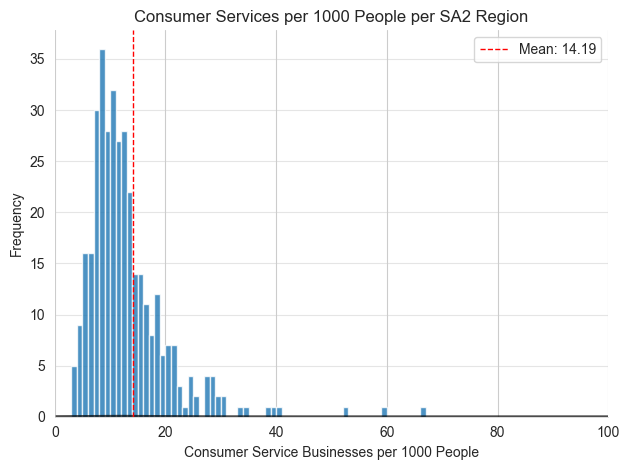

In [100]:
sns.set_style("whitegrid")
# plt.figure(figsize=(10, 6)) 
plt.hist(total_view["consumer_per_1k"], bins=np.arange(0,100,1), alpha=0.8)
sns.kdeplot(total_view["consumer_per_1k"], color="black", linewidth=2, alpha=0.7)
plt.title("Consumer Services per 1000 People per SA2 Region")
plt.xlabel("Consumer Service Businesses per 1000 People")
plt.ylabel("Frequency")
# Add vertical line for mean
plt.axvline(total_view["consumer_per_1k"].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {total_view["consumer_per_1k"].mean():.2f}')
plt.legend()

# Grid customization
plt.grid(axis='y', alpha=0.5)  # Lighter gridlines
plt.xlim(0, 100) 
# Remove top and right spines, add light border
sns.despine()  # Remove top and right spines
plt.gca().spines['bottom'].set_linewidth(0.5)  # Thinner bottom spine
plt.gca().spines['left'].set_linewidth(0.5)  # Thinner left spine

plt.tight_layout()
plt.show()

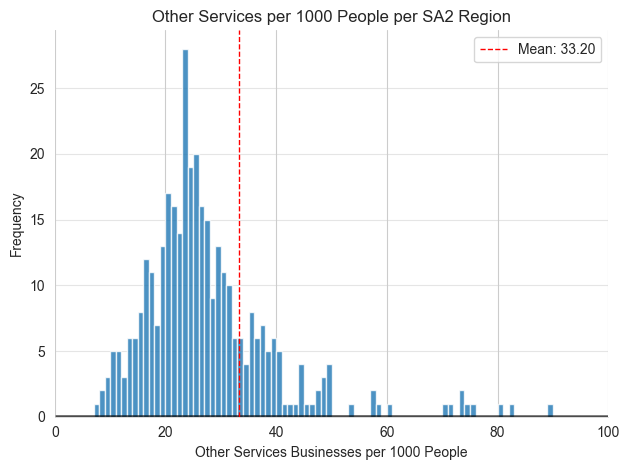

In [101]:
sns.set_style("whitegrid")
# plt.figure(figsize=(10, 6)) 
plt.hist(total_view["others_per_1k"], bins=np.arange(0,100,1), alpha=0.8)
sns.kdeplot(total_view["others_per_1k"], color="black", linewidth=2, alpha=0.7)
plt.title("Other Services per 1000 People per SA2 Region")
plt.xlabel("Other Services Businesses per 1000 People")
plt.ylabel("Frequency")
# Add vertical line for mean
plt.axvline(total_view["others_per_1k"].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {total_view["others_per_1k"].mean():.2f}')
plt.legend()

# Grid customization
plt.grid(axis='y', alpha=0.5)  # Lighter gridlines
plt.xlim(0, 100) 
# Remove top and right spines, add light border
sns.despine()  # Remove top and right spines
plt.gca().spines['bottom'].set_linewidth(0.5)  # Thinner bottom spine
plt.gca().spines['left'].set_linewidth(0.5)  # Thinner left spine

plt.tight_layout()
plt.show()

### Stops

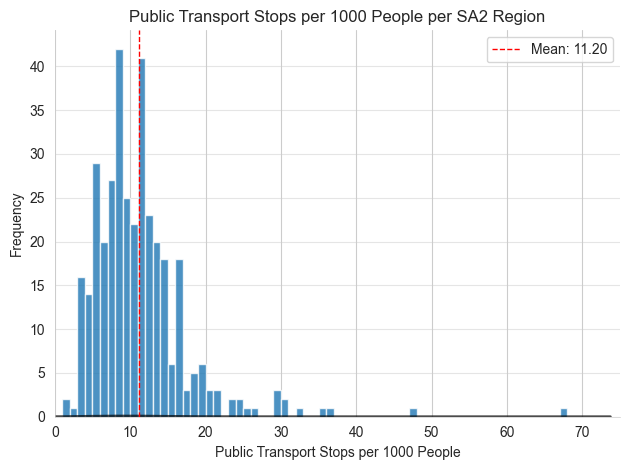

In [102]:
sns.set_style("whitegrid")
# plt.figure(figsize=(10, 6)) 
plt.hist(total_view["stops_per_1k"], bins=np.arange(0,100,1), alpha=0.8)
sns.kdeplot(total_view["stops_per_1k"], color="black", linewidth=2, alpha=0.7)
plt.title("Public Transport Stops per 1000 People per SA2 Region")
plt.xlabel("Public Transport Stops per 1000 People")
plt.ylabel("Frequency")
# Add vertical line for mean
plt.axvline(total_view["stops_per_1k"].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {total_view["stops_per_1k"].mean():.2f}')
plt.legend()

# Grid customization
plt.grid(axis='y', alpha=0.5)  # Lighter gridlines
plt.xlim(0, 75) 
# Remove top and right spines, add light border
sns.despine()  # Remove top and right spines
plt.gca().spines['bottom'].set_linewidth(0.5)  # Thinner bottom spine
plt.gca().spines['left'].set_linewidth(0.5)  # Thinner left spine

plt.tight_layout()
plt.show()

### Polls

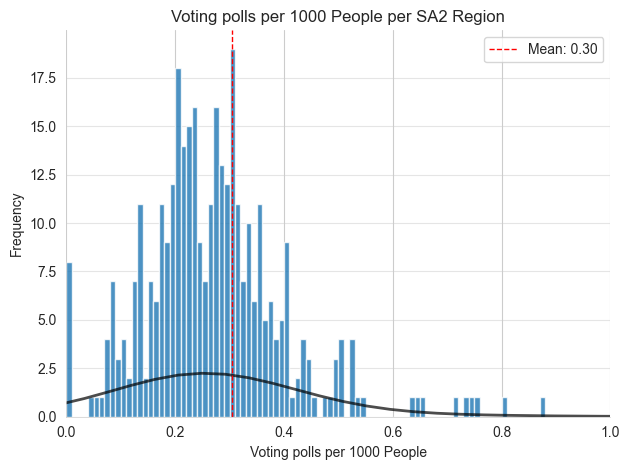

In [103]:
sns.set_style("whitegrid")
# plt.figure(figsize=(10, 6)) 
plt.hist(total_view["polls_per_1k"], bins=np.arange(0,100,0.01), alpha=0.8)
sns.kdeplot(total_view["polls_per_1k"], color="black", linewidth=2, alpha=0.7)
plt.title("Voting polls per 1000 People per SA2 Region")
plt.xlabel("Voting polls per 1000 People")
plt.ylabel("Frequency")
# Add vertical line for mean
plt.axvline(total_view["polls_per_1k"].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {total_view["polls_per_1k"].mean():.2f}')
plt.legend()

# Grid customization
plt.grid(axis='y', alpha=0.5)  # Lighter gridlines
plt.xlim(0, 1) 
# Remove top and right spines, add light border
sns.despine()  # Remove top and right spines
plt.gca().spines['bottom'].set_linewidth(0.5)  # Thinner bottom spine
plt.gca().spines['left'].set_linewidth(0.5)  # Thinner left spine

plt.tight_layout()
plt.show()

### Schools

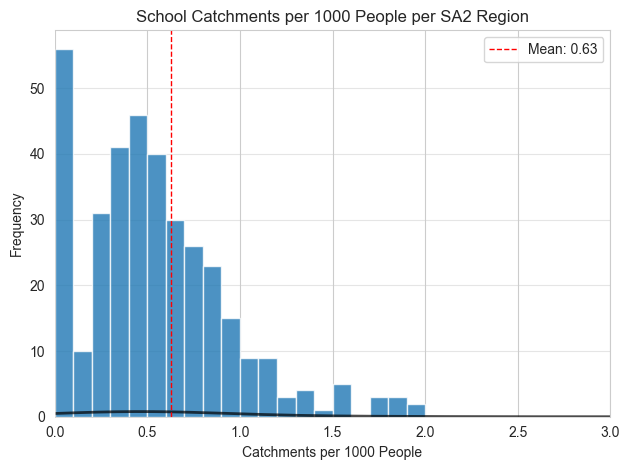

In [104]:
sns.set_style("whitegrid")
# plt.figure(figsize=(10, 6)) 
plt.hist(total_view["schools_per_1k"], bins=np.arange(0,100,0.1), alpha=0.8)
sns.kdeplot(total_view["schools_per_1k"], color="black", linewidth=2, alpha=0.7)
plt.title("School Catchments per 1000 People per SA2 Region")
plt.xlabel("Catchments per 1000 People")
plt.ylabel("Frequency")
# Add vertical line for mean
plt.axvline(total_view["schools_per_1k"].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {total_view["schools_per_1k"].mean():.2f}')
plt.legend()

# Grid customization
plt.grid(axis='y', alpha=0.5)  # Lighter gridlines
plt.xlim(0, 3) 
# Remove top and right spines, add light border
# sns.despine()  # Remove top and right spines
plt.gca().spines['bottom'].set_linewidth(0.5)  # Thinner bottom spine
plt.gca().spines['left'].set_linewidth(0.5)  # Thinner left spine

plt.tight_layout()
plt.show()

### Building approvals

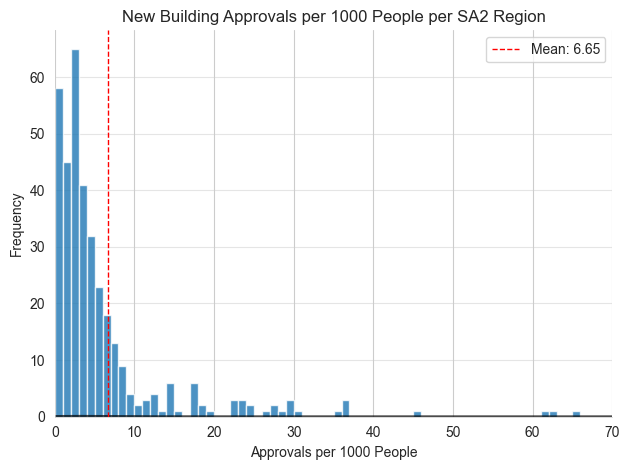

In [105]:
sns.set_style("whitegrid")
# plt.figure(figsize=(10, 6)) 
plt.hist(total_view["buildings_per_1k"], bins=np.arange(0,100,1), alpha=0.8)
sns.kdeplot(total_view["buildings_per_1k"], color="black", linewidth=2, alpha=0.7)
plt.title("New Building Approvals per 1000 People per SA2 Region")
plt.xlabel("Approvals per 1000 People")
plt.ylabel("Frequency")
# Add vertical line for mean
plt.axvline(total_view["buildings_per_1k"].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {total_view["buildings_per_1k"].mean():.2f}')
plt.legend()

# Grid customization
plt.grid(axis='y', alpha=0.5)  # Lighter gridlines
plt.xlim(0, 70) 
# Remove top and right spines, add light border
sns.despine()  # Remove top and right spines
plt.gca().spines['bottom'].set_linewidth(0.5)  # Thinner bottom spine
plt.gca().spines['left'].set_linewidth(0.5)  # Thinner left spine

plt.tight_layout()
plt.show()

### Location Facilities

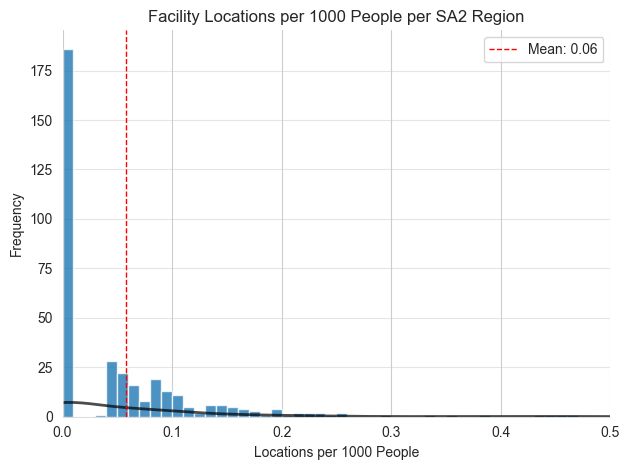

In [106]:
sns.set_style("whitegrid")
# plt.figure(figsize=(10, 6)) 
plt.hist(total_view["facilities_per_1k"], bins=np.arange(0,100,0.01), alpha=0.8)
sns.kdeplot(total_view["facilities_per_1k"], color="black", linewidth=2, alpha=0.7)
plt.title("Facility Locations per 1000 People per SA2 Region")
plt.xlabel("Locations per 1000 People")
plt.ylabel("Frequency")
# Add vertical line for mean
plt.axvline(total_view["facilities_per_1k"].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {total_view["facilities_per_1k"].mean():.2f}')
plt.legend()

# Grid customization
plt.grid(axis='y', alpha=0.5)  # Lighter gridlines
plt.xlim(0, 0.5) 
# Remove top and right spines, add light border
sns.despine()  # Remove top and right spines
plt.gca().spines['bottom'].set_linewidth(0.5)  # Thinner bottom spine
plt.gca().spines['left'].set_linewidth(0.5)  # Thinner left spine

plt.tight_layout()
plt.show()

### Score comparison

In [107]:
map_score = gpd.read_file('SA2_2021_AUST_GDA2020.shp')
map_score = df[df['GCC_NAME21'] == 'Greater Sydney']
map_score = map_score.drop(columns=['GCC_CODE21', 'GCC_NAME21',
                          'SA3_CODE21', 'SA3_NAME21',
                          'SA4_CODE21', 'SA4_NAME21',
                          'STE_CODE21', 'STE_NAME21',
                          'AUS_CODE21', 'AUS_NAME21',
                          'CHG_FLAG21', 'CHG_LBL21',
                          'LOCI_URI21'])
map_score.columns = [
    'sa2_code',
    'sa2_name',
    'area',
    'geometry'
]
map_score['sa2_code'] = map_score['sa2_code'].astype('int32')
total_scores["sa2_code"] = total_scores["sa2_code"].astype("int32")
map_score = map_score.loc[map_score["sa2_code"].isin(total_scores["sa2_code"].values)]
map_score = map_score.sort_values(by=["sa2_code"], ascending=True)
map_score = map_score.reset_index(drop=True)
total_scores = total_scores.sort_values(by=["sa2_code"], ascending=True)
total_scores = total_scores.reset_index(drop=True)
map_score["score"] = total_scores["score"]
map_score["extended_score"] = total_scores["extended_score"]
map_score.head()

,sa2_code,sa2_name,area,geometry,score,extended_score
0,102011028,Avoca Beach - Copacabana,6.4376,"POLYGON ((151.41373 -33.46558, 151.41362 -33.4...",0.625511,0.439036
1,102011029,Box Head - MacMasters Beach,32.0802,"POLYGON ((151.37484 -33.50052, 151.37507 -33.5...",0.792156,0.579303
2,102011030,Calga - Kulnura,767.9512,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448...",1.000000,1.000000
3,102011031,Erina - Green Point,33.7934,"POLYGON ((151.37194 -33.43698, 151.37288 -33.4...",0.960894,0.878359
4,102011032,Gosford - Springfield,16.9123,"POLYGON ((151.32349 -33.42779, 151.32342 -33.4...",0.797483,0.991112


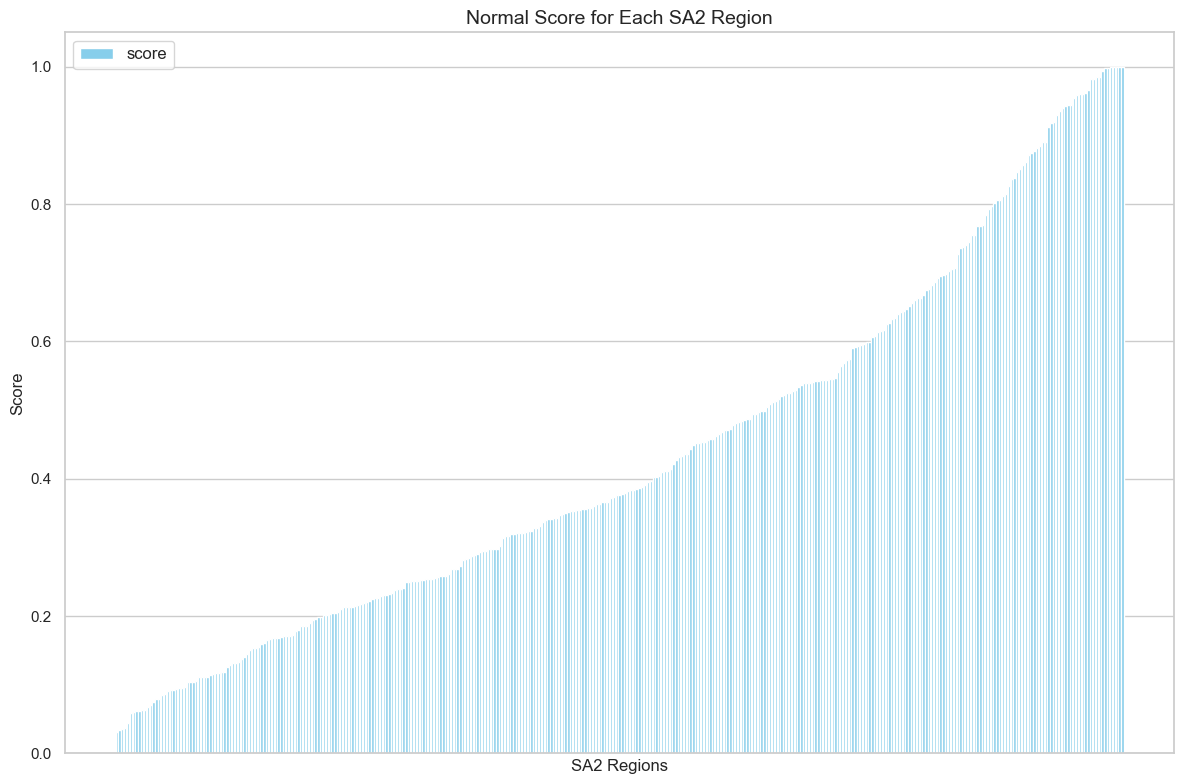

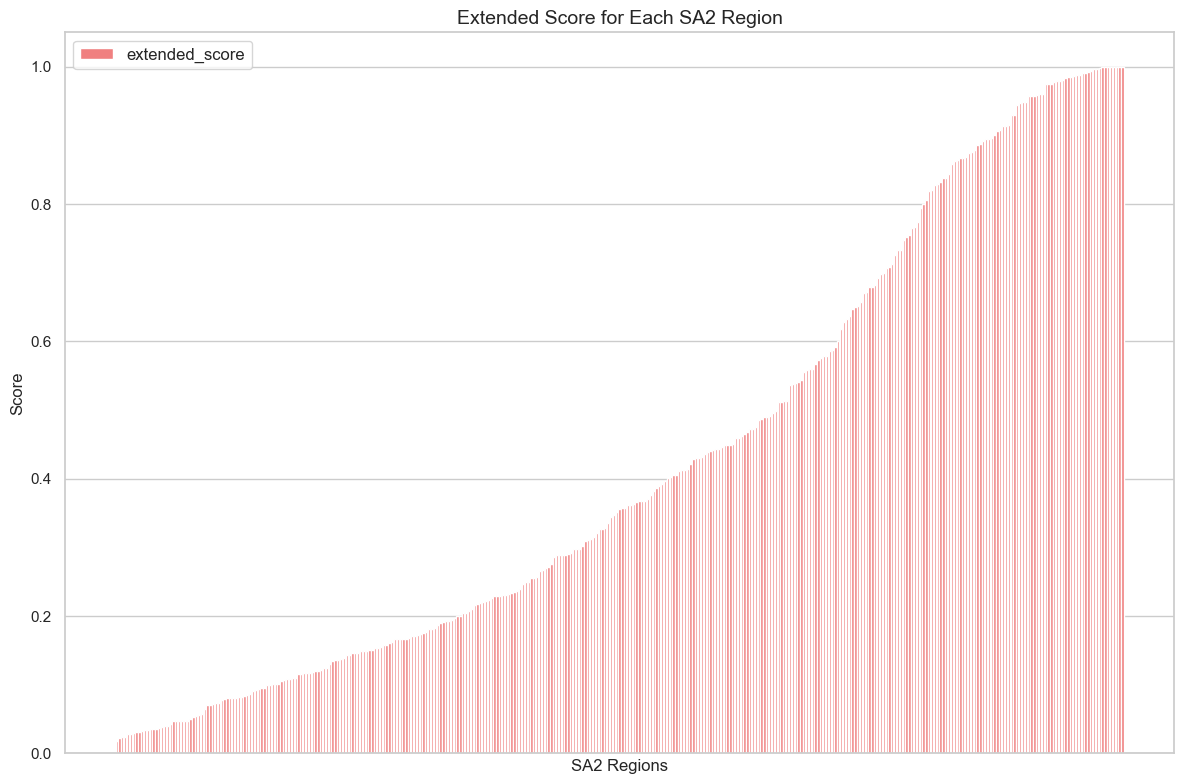

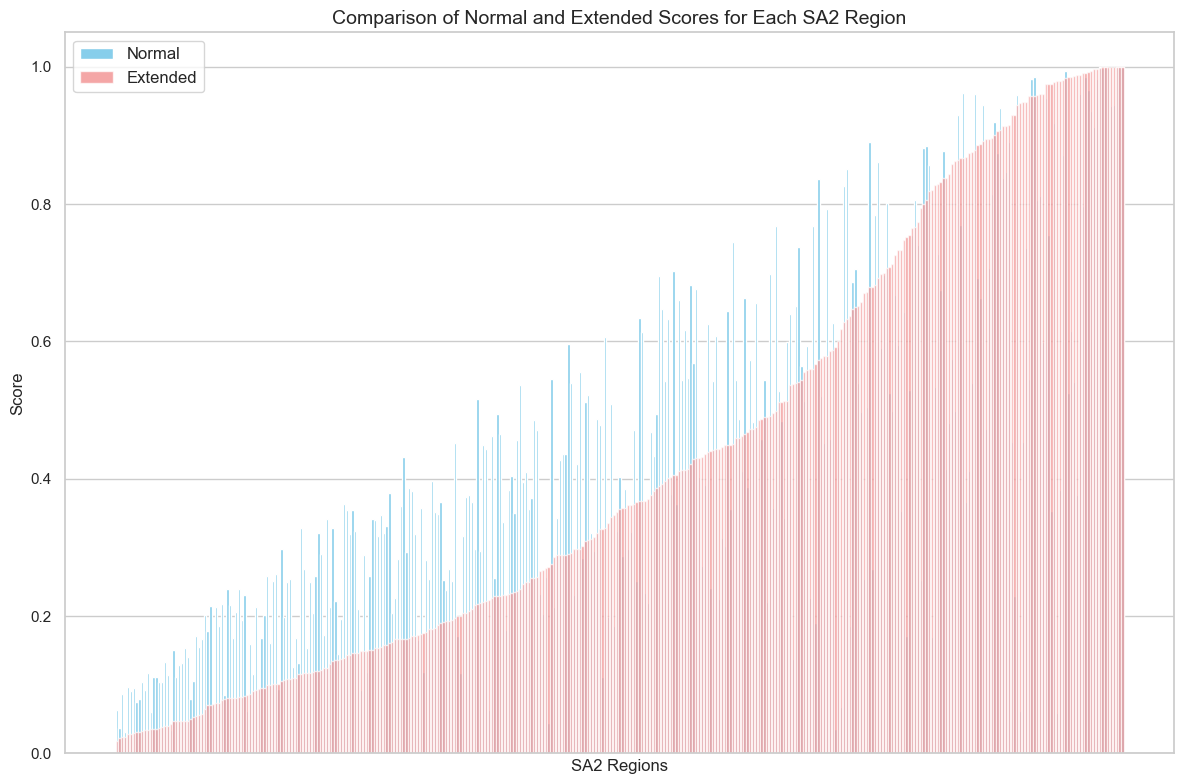

In [108]:
sns.set_theme(style="whitegrid")

# Function to plot scores (unchanged from the previous version)
def plot_scores(data, score_type, color, alpha=1, title=None):
    plt.figure(figsize=(12, 8))
    plt.bar(data["sa2_code"].astype("str"), data[score_type], color=color, alpha=alpha, label=score_type)
    plt.xticks(ticks=[], labels=[])
    plt.xlabel("SA2 Regions", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    if title:
        plt.title(title, fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Sort by normal score and plot
total_scores_sorted = total_scores.sort_values(by=["score"], ascending=True)
plot_scores(total_scores_sorted, "score", "skyblue", title="Normal Score for Each SA2 Region")

# Sort by extended score and plot
total_scores_sorted = total_scores.sort_values(by=["extended_score"], ascending=True)
plot_scores(total_scores_sorted, "extended_score", "lightcoral", title="Extended Score for Each SA2 Region")

# Combine scores in one plot
plt.figure(figsize=(12, 8))
plt.bar(total_scores_sorted["sa2_code"].astype("str"), total_scores_sorted["score"], color="skyblue", label="Normal")
plt.bar(total_scores_sorted["sa2_code"].astype("str"), total_scores_sorted["extended_score"], color="lightcoral", alpha=0.7, label="Extended")
plt.xticks(ticks=[], labels=[])
plt.xlabel("SA2 Regions", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Comparison of Normal and Extended Scores for Each SA2 Region", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

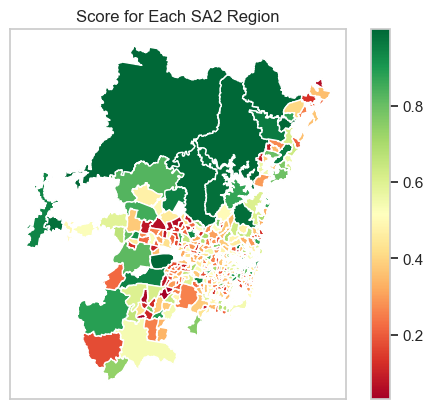

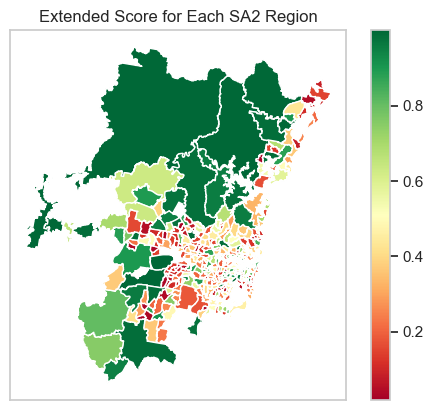

In [109]:
# Map of scores for each region
f, ax = plt.subplots(1)
ax = map_score.plot(ax=ax, column="score", cmap='RdYlGn', legend=True)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.title("Score for Each SA2 Region")
plt.show()

f, ax = plt.subplots(1)
ax = map_score.plot(ax=ax, column="extended_score",cmap='RdYlGn', legend=True)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.title("Extended Score for Each SA2 Region")
plt.show()

In [110]:
geo_data = map_score.to_json()

### Correlation Analysis

In [111]:
# Calculate Pearson correlation between the original score and median income
score_income_correlation = total_scores['score'].corr(total_scores['median_income'], method="pearson")

# Calculate Pearson correlation between the extended score and median income
extended_score_income_correlation = total_scores['extended_score'].corr(total_scores['median_income'], method="pearson")

# Print the results
print("Correlation between score and median income:", score_income_correlation)
print("Correlation between extended score and median income:", extended_score_income_correlation)


Correlation between score and median income: 0.09074793442751782
Correlation between extended score and median income: 0.11339094325673343


Coefficient (Score): 3492.0607


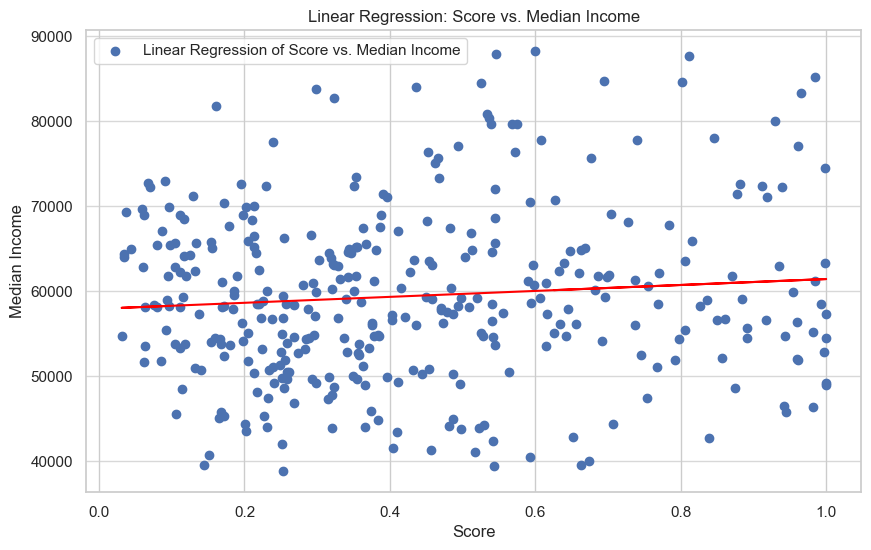

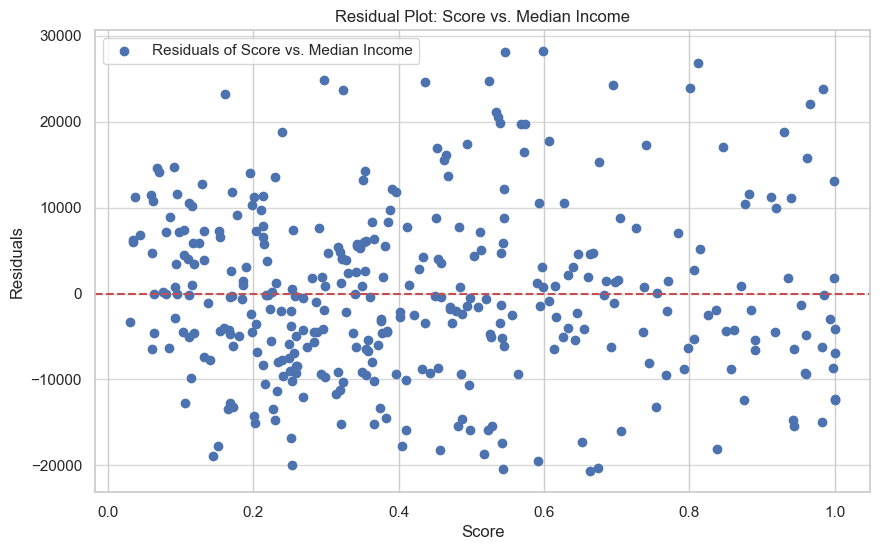

Coefficient (Extended Score): 3627.8890


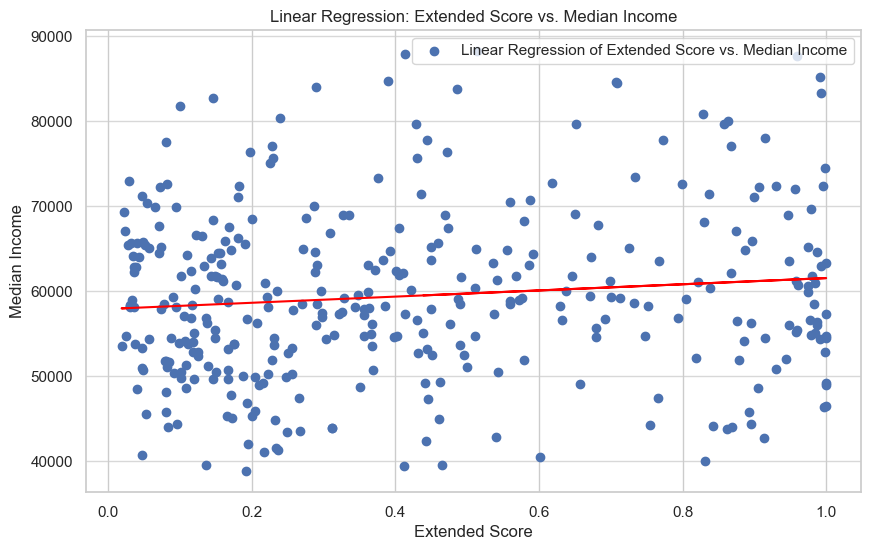

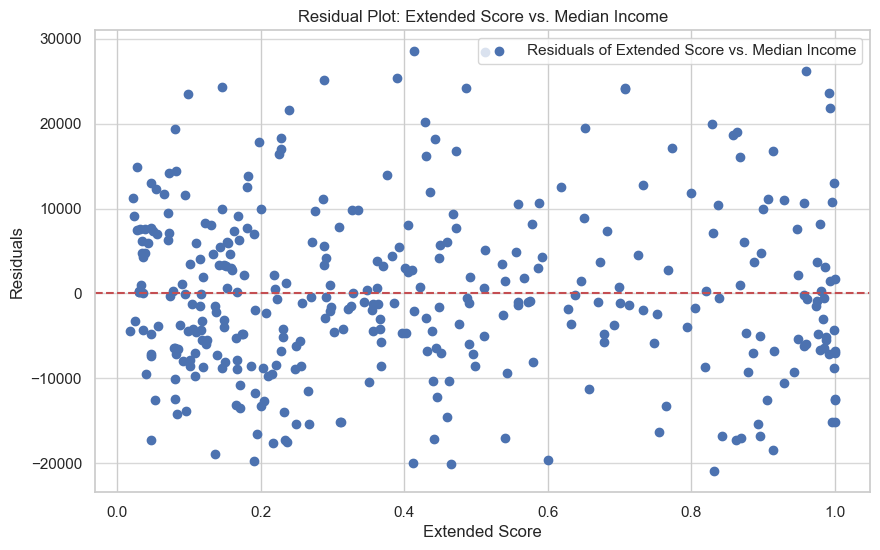

In [112]:
def analyze_score_income_relationship(score_type, scores, median_income):
    """
    Plots a scatterplot, linear regression line, and residual plot of a given score against normalized median income.
    """



    plt.figure(figsize=(10, 6))

    # Scatterplot
    plt.scatter(scores, median_income, label=f"Linear Regression of {score_type} vs. Median Income")
    plt.title(f"Linear Regression: {score_type} vs. Median Income")
    plt.xlabel(score_type)
    plt.ylabel("Median Income")
    plt.legend()
    plt.grid(axis='y', alpha=0.75)

    # Linear Regression
    slope, intercept = np.polyfit(scores, median_income, 1)
    plt.plot(scores, slope * scores + intercept, color="red", label="Regression Line")

    # Calculate Residuals
    predicted_values = slope * scores + intercept
    residuals = median_income - predicted_values

    print(f"Coefficient ({score_type}): {slope:.4f}")

    # Residual Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(scores, residuals, label=f"Residuals of {score_type} vs. Median Income")
    plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
    plt.title(f"Residual Plot: {score_type} vs. Median Income")
    plt.xlabel(score_type)
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Analyze and visualize
analyze_score_income_relationship("Score", total_scores['score'], total_scores['median_income'])
analyze_score_income_relationship("Extended Score", total_scores['extended_score'], total_scores['median_income'])

# Section 4

## Rankings

### Businesses

In [113]:
conn.execute(text("""
drop view if exists consumer_ranking cascade;
create view consumer_ranking as
select p.sa2_code, coalesce(sum(total_no), 0) as total_businesses,
rank() over (order by sum(total_no) desc) as consumer_rank,
dense_rank() over (order by sum(total_no) desc) as consumer_dense_rank
from population p
inner join sa2_regions a using (sa2_code)
left join businesses b on (p.sa2_code = b.sa2_code) and (ind_code = 'G' or ind_code = 'H' or ind_code = 'R')
where p.total >= 100 and a.sa2_code is not null
group by p.sa2_code;
"""))

query(conn, "select * from consumer_ranking")

,sa2_code,total_businesses,consumer_rank,consumer_dense_rank
0,117031644,2790,1,1
1,117031645,1214,2,2
2,117031336,845,3,3
3,121011684,663,4,4
4,117031330,599,5,5
...,...,...,...,...
355,102021049,36,355,216
356,116021562,31,357,217
357,102011035,25,358,218
358,102021052,24,359,219


In [114]:
conn.execute(text("""
drop view if exists others_ranking cascade;
create view others_ranking as
select p.sa2_code, coalesce(sum(total_no), 0) as total_businesses,
rank() over (order by sum(total_no) desc) as others_rank,
dense_rank() over (order by sum(total_no) desc) as others_dense_rank
from population p
inner join sa2_regions a using (sa2_code)
left join businesses b on (p.sa2_code = b.sa2_code) and (ind_code = 'N' or ind_code = 'I' or ind_code = 'Q' or ind_code = 'K')
where p.total >= 100 and a.sa2_code is not null
group by p.sa2_code;
"""))

query(conn, "select * from others_ranking")

,sa2_code,total_businesses,others_rank,others_dense_rank
0,117031644,13194,1,1
1,121041417,2039,2,2
2,118011341,1821,3,3
3,115011291,1599,4,4
4,117031645,1533,5,5
...,...,...,...,...
355,102021049,74,356,276
356,102021052,65,357,277
357,128021533,64,358,278
358,115031299,55,359,279


### Stops

In [115]:
conn.execute(text("""
drop view if exists stops_ranking cascade;
create view stops_ranking as
select sa2_code, coalesce(num_stop_ids, 0) as num_stop_ids,
       rank() over (order by num_stop_ids desc) as stop_id_rank,
       dense_rank() over (order by num_stop_ids desc) as dense_stop_id_rank
from (
    select sa2_code, count(stop_id) as num_stop_ids 
    from population p
    inner join sa2_regions a using (sa2_code)
	left join stops s on st_contains(a.geom, s.geom)
	where sa2_code is not null and p.total >= 100
    group by sa2_code
) as stop_id_counts;
"""))

query(conn, "select * from stops_ranking")

,sa2_code,num_stop_ids,stop_id_rank,dense_stop_id_rank
0,115021297,697,1,1
1,124011454,435,2,2
2,124011452,395,3,3
3,102011040,387,4,4
4,123021437,375,5,5
...,...,...,...,...
355,117031648,31,356,205
356,117031646,24,357,206
357,117011320,18,358,207
358,119041671,12,359,208


### Polls

In [116]:
conn.execute(text("""
drop view if exists polls_ranking cascade;
create view polls_ranking as
select sa2_code, coalesce(polling_place_id, 0) as num_polling_place_id,
       rank() over (order by polling_place_id desc) as poll_id_rank,
       dense_rank() over (order by polling_place_id desc) as dense_poll_id_rank
from (
    select sa2_code, count(polling_place_id) as polling_place_id 
    from population p
    inner join sa2_regions a using (sa2_code)
	left join polls pol on st_contains(a.geom, pol.geom)
	where sa2_code is not null and p.total >= 100
    group by sa2_code
) as polling_place_id_counts;
"""))

query(conn, "select * from polls_ranking")

,sa2_code,num_polling_place_id,poll_id_rank,dense_poll_id_rank
0,117031644,64,1,1
1,117031645,27,2,2
2,125041717,18,3,3
3,121011684,16,4,4
4,124031464,13,5,5
...,...,...,...,...
355,119011355,0,353,16
356,115011557,0,353,16
357,116021631,0,353,16
358,116021629,0,353,16


### Schools

In [117]:
conn.execute(text("""
drop view if exists schools_ranking cascade;
create view schools_ranking as
with population as (
select sa2_code, total,
	age_group_0_4 + age_group_5_9 + age_group_10_14 + age_group_15_19 as young_people, 
	geom
from sa2_regions
join population using (sa2_code)
where total >= 100
)
select sa2_code, coalesce(id, 0) as num_school_id,
       rank() over (order by id desc) as school_id_rank,
       dense_rank() over (order by id desc) as dense_school_id_rank
from (
    select sa2_code, count(id) as id 
    from population p
    inner join sa2_regions a using (sa2_code)
	left join school s on st_intersects(a.geom, s.geom)
        and (st_area(st_intersection(a.geom, s.geom))/st_area(s.geom)) > 0.5
	where sa2_code is not null
    group by sa2_code
) as school_id_counts;
"""))

query(conn, "select * from schools_ranking")

,sa2_code,num_school_id,school_id_rank,dense_school_id_rank
0,115031300,9,1,1
1,102011030,9,1,1
2,115021297,8,3,2
3,128021536,7,4,3
4,127011504,7,4,3
...,...,...,...,...
355,121041414,0,305,10
356,121021577,0,305,10
357,121011684,0,305,10
358,116021562,0,305,10


### Building approvals

In [118]:
conn.execute(text("""
drop view if exists new_buildings_ranking cascade;
create view new_buildings_ranking as
select p.sa2_code, coalesce(total_new, 0) as total_new_buildings,
rank() over (order by total_new desc) as new_buildings_rank,
dense_rank() over (order by total_new desc) as new_buildings_dense_rank
from population p
inner join sa2_regions a using (sa2_code)
left join building_approvals b on (p.sa2_code = b.sa2_code)
where p.total >= 100 and total is not null
group by p.sa2_code, total_new;
"""))

query(conn, "select * from new_buildings_ranking")

,sa2_code,total_new_buildings,new_buildings_rank,new_buildings_dense_rank
0,116021632,1659,1,1
1,115041623,1303,2,2
2,126021500,1099,3,3
3,116021629,954,4,4
4,127011505,789,5,5
...,...,...,...,...
355,117011320,0,354,167
356,117031645,0,354,167
357,119011355,0,354,167
358,119041671,0,354,167


### Facility locations

In [119]:
conn.execute(text("""
drop view if exists location_facilities_ranking cascade;
create view location_facilities_ranking as
select sa2_code, coalesce(num_locations, 0) as num_locations,
       rank() over (order by num_locations desc) as num_locations_rank,
       dense_rank() over (order by num_locations desc) as dense_num_locations_rank
from (
    select sa2_code, count(location_name) as num_locations 
    from population p
    inner join sa2_regions a using (sa2_code)
	left join location_facilities lf on st_contains(a.geom, lf.geom)
	where sa2_code is not null and p.total >= 100
    group by sa2_code
) as location_facilities_counts;
"""))

query(conn, "select * from location_facilities_ranking")

,sa2_code,num_locations,num_locations_rank,dense_num_locations_rank
0,117031644,10,1,1
1,117031645,9,2,2
2,120031394,7,3,3
3,117031641,6,4,4
4,124011453,5,5,5
...,...,...,...,...
355,127021514,0,175,10
356,127021516,0,175,10
357,127021517,0,175,10
358,127021518,0,175,10


### Combining tables

In [120]:
conn.execute(text("""
drop view if exists combined_ranking cascade;
create view combined_ranking as
select c.sa2_code, consumer_dense_rank, others_dense_rank, dense_stop_id_rank,
		dense_poll_id_rank, dense_school_id_rank, new_buildings_dense_rank,
		dense_num_locations_rank
from stops_ranking s
left join others_ranking o on (s.sa2_code = o.sa2_code)
left join consumer_ranking c on (s.sa2_code = c.sa2_code)
left join polls_ranking p on (s.sa2_code = p.sa2_code)
left join schools_ranking sc on (s.sa2_code = sc.sa2_code)
left join new_buildings_ranking b on (s.sa2_code = b.sa2_code)
left join location_facilities_ranking lf on (s.sa2_code = lf.sa2_code);
"""))

query(conn, "select * from combined_ranking")

,sa2_code,consumer_dense_rank,others_dense_rank,dense_stop_id_rank,dense_poll_id_rank,dense_school_id_rank,new_buildings_dense_rank,dense_num_locations_rank
0,102011028,173,240,126,14,9,129,10
1,102011029,161,238,62,14,7,136,10
2,102011030,168,245,96,9,1,157,9
3,102011031,62,109,24,10,6,152,10
4,102011032,37,57,7,9,7,6,9
...,...,...,...,...,...,...,...,...
355,128021536,116,166,37,9,3,125,8
356,128021538,71,91,78,10,6,41,8
357,128021607,149,231,58,9,6,103,9
358,128021608,212,275,115,14,9,153,9


In [121]:
conn.execute(text("""
drop view if exists combined_ranking cascade;
create view combined_ranking as
select c.sa2_code, consumer_rank, others_rank, stop_id_rank,
		poll_id_rank, school_id_rank, new_buildings_rank,
		num_locations_rank
from stops_ranking s
left join others_ranking o on (s.sa2_code = o.sa2_code)
left join consumer_ranking c on (s.sa2_code = c.sa2_code)
left join polls_ranking p on (s.sa2_code = p.sa2_code)
left join schools_ranking sc on (s.sa2_code = sc.sa2_code)
left join new_buildings_ranking b on (s.sa2_code = b.sa2_code)
left join location_facilities_ranking lf on (s.sa2_code = lf.sa2_code);
"""))

query(conn, "select * from combined_ranking")

,sa2_code,consumer_rank,others_rank,stop_id_rank,poll_id_rank,school_id_rank,new_buildings_rank,num_locations_rank
0,102011028,282,311,196,265,191,209,175
1,102011029,256,309,80,265,59,231,175
2,102011030,270,319,139,22,1,297,64
3,102011031,70,121,24,49,31,280,175
4,102011032,41,58,7,22,59,6,64
...,...,...,...,...,...,...,...,...
355,128021536,162,197,42,22,4,198,22
356,128021538,83,100,105,49,31,42,22
357,128021607,223,299,72,22,31,132,64
358,128021608,348,355,170,265,191,287,64


### Normalizing the rankings

In [122]:
conn.execute(text("""
drop view if exists improved_scoring cascade;
create view improved_scoring as
WITH normalized_ranks AS (
    SELECT
        sa2_code,
        (consumer_rank - 1.0) / (360 - 1) as norm_rank_consumer,
		(others_rank - 1.0) / (360 - 1) AS norm_rank_others,
        (stop_id_rank - 1.0) / (360 - 1) AS norm_rank_stops,
        (poll_id_rank - 1.0) / (360 - 1) AS norm_rank_polls,
        (school_id_rank - 1.0) / (360 - 1) AS norm_rank_schools,
		(new_buildings_rank - 1.0) / (360 - 1) AS norm_rank_buildings,
		(num_locations_rank - 1.0) / (360 - 1) AS norm_rank_facilities
    FROM combined_ranking
),
                  
inverted_ranks as (
    SELECT
        sa2_code,
        1 - norm_rank_consumer AS inv_rank_consumer,
        1 - norm_rank_others AS inv_rank_others,
        1 - norm_rank_stops AS inv_rank_stops,
        1 - norm_rank_polls AS inv_rank_polls,
        1 - norm_rank_schools AS inv_rank_schools,
        1 - norm_rank_buildings AS inv_rank_buildings,
        1 - norm_rank_facilities AS inv_rank_facilities
    FROM normalized_ranks          
)

                  
SELECT
    sa2_code,
    sum(inv_rank_consumer + inv_rank_others +  inv_rank_stops 
     +  inv_rank_polls +  inv_rank_schools) / 5 AS bustling_score
FROM inverted_ranks
group by sa2_code;
"""))

query(conn, "select * from improved_scoring")

,sa2_code,bustling_score
0,117031643,0.452925
1,128011606,0.435097
2,126021501,0.587187
3,123011700,0.278552
4,125041588,0.677994
...,...,...
355,125031484,0.774373
356,127031522,0.501393
357,125031480,0.710306
358,122031432,0.226184


### Correlation analysis

In [123]:
conn.execute(text("""
drop view if exists total_scores cascade;
create view total_scores as
select CORR(bustling_score, score) AS income_bustling_corr
from score
natural join extended_score
natural join improved_scoring
natural join median_income
natural join combined_z_score;
"""))
query(conn, "select * from total_scores")

,income_bustling_corr
0,0.297971


## Machine Learning

### Overview of the dataframe

In [124]:
total_view.head()

,sa2_code,area,geom,consumer_per_1k,others_per_1k,stops_per_1k,polls_per_1k,schools_per_1k,buildings_per_1k,facilities_per_1k,score,extended_score,earners,median_age,median_income,mean_income
0,102011028,6.4376,0106000020E6100000010000000103000000010000005E...,12.881806,23.240372,16.865870,0.265604,0.471476,5.179283,0.000000,0.625511,0.439036,4749,47,55065,77615
1,102011029,32.0802,0106000020E61000000100000001030000000100000010...,10.314875,16.286645,19.453493,0.180963,1.214083,2.895404,0.000000,0.792156,0.579303,6636,49,51927,71509
2,102011030,767.9512,0106000020E61000000200000001030000000100000085...,21.693345,35.172704,36.225779,1.474305,9.365245,2.106150,0.210615,1.000000,1.000000,2965,49,49168,63802
3,102011031,33.7934,0106000020E61000000100000001030000000100000041...,18.374654,31.412552,19.252854,0.405323,1.248050,1.080862,0.000000,0.960894,0.878359,8010,48,51905,71992
4,102011032,16.9123,0106000020E6100000010000000103000000010000007E...,15.506418,28.670477,16.630750,0.327930,0.687443,36.259721,0.046847,0.797483,0.991112,12051,41,54372,65283


### Importing modules

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from scipy import stats

### Cleaning data and splitting them into testing and training sets

In [126]:
np.random.seed(0)

y = total_view['median_income']
X = total_view.drop(['median_income','geom','mean_income','median_age','score','extended_score','sa2_code', 'area'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [127]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((252, 8), (108, 8), (252,), (108,))

### Creating a Linear regression model and fitting the data

In [128]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [129]:
model.intercept_

53230.684298419

In [130]:
model.coef_

array([ 4.33817457e+02, -7.80535187e+01, -1.71230553e+02, -1.87824982e+03,
       -1.34258709e+02,  5.85383673e+01,  5.17535832e+02,  5.83371119e-01])

### Testing the model's prediction

In [131]:
y_pred = model.predict(X_test)
y_pred

array([57638.36826196, 61374.88539887, 61546.69997369, 57531.17188673,
       59179.61473388, 55532.75726721, 55473.16707603, 57397.63062693,
       59260.23363137, 60199.43261435, 68656.85321349, 60722.31190097,
       62801.91303765, 59414.43154194, 59586.44090314, 58824.80364447,
       60304.70508675, 61166.87932277, 58954.74024657, 58754.58417978,
       58506.8460881 , 59192.663297  , 64475.41306639, 57028.20505271,
       58143.17978456, 57372.82769908, 57695.42880736, 58241.77095296,
       61921.55851124, 73504.76179308, 60252.20047871, 52837.08845439,
       58595.31213326, 58245.9777131 , 63797.0061738 , 60404.69049567,
       54039.1634651 , 54174.12602282, 65134.69539724, 65538.87081275,
       62875.69791406, 61103.10367948, 62067.53652473, 57974.32368565,
       60291.28220028, 57664.65470595, 58580.49486906, 54768.65520221,
       60291.59663281, 59553.8403662 , 58470.1597041 , 55557.95071918,
       62228.36614862, 65876.99093948, 55907.36176158, 59530.42291114,
      

In [132]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 98145468.82
Mean Absolute Error: 7298.22
R-squared: -0.03


In [133]:
X2 = sm.add_constant(X) 
model_sm = sm.OLS(y, X2).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:          median_income   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     4.758
Date:                Fri, 12 Jul 2024   Prob (F-statistic):           1.46e-05
Time:                        11:44:09   Log-Likelihood:                -3813.0
No. Observations:                 360   AIC:                             7644.
Df Residuals:                     351   BIC:                             7679.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               5.42e+04   2053.94

In [134]:
importance = np.abs(model.coef_)
feature_names = X.columns
sorted_idx = importance.argsort()[::-1]  # Sort in descending order

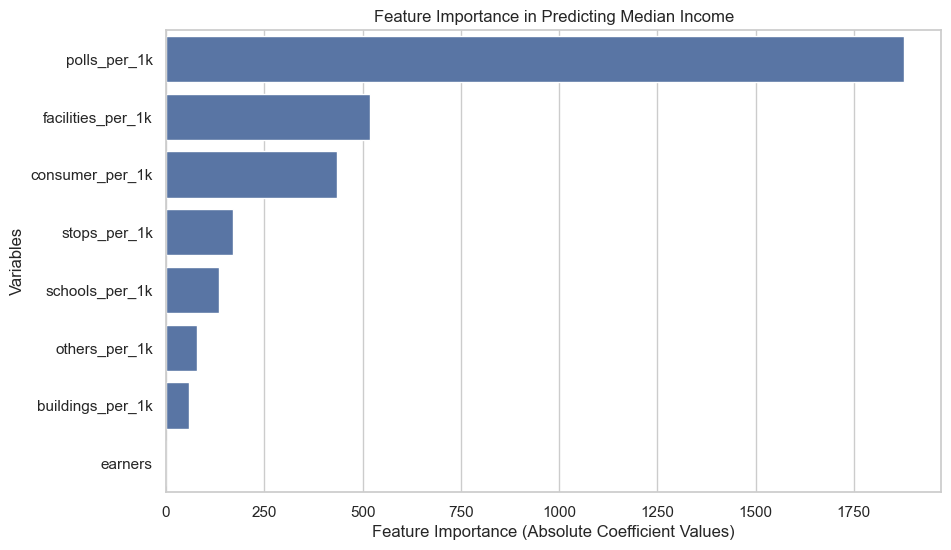

In [135]:
plt.figure(figsize=(10, 6))
sns.barplot(x=importance[sorted_idx], y=feature_names[sorted_idx])
plt.xlabel('Feature Importance (Absolute Coefficient Values)')
plt.ylabel('Variables')
plt.title('Feature Importance in Predicting Median Income')
plt.show()

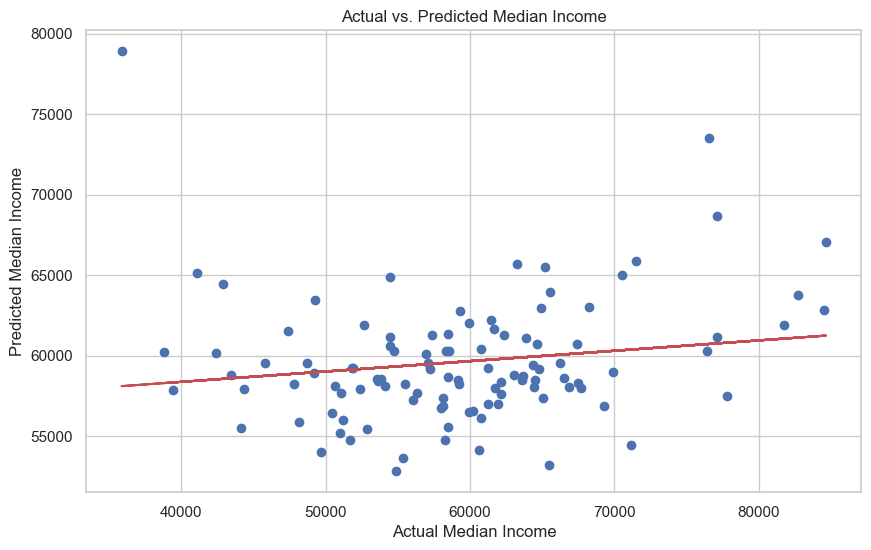

In [136]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Median Income')
plt.ylabel('Predicted Median Income')
plt.title('Actual vs. Predicted Median Income')
slope, intercept, _, _, _ = stats.linregress(y_test, y_pred)
plt.plot(y_test, intercept + slope * y_test, 'r', label=f'Regression Line (R² = {r2:.2f})')

plt.show()